# Qian's experiment outputs on a circumpolar view

The directories of Qian's experiment are listed as follows:

1/ wind + thermal perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthp

2/ wind + thermal +meltwater perturbation run:
/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_qian_wthmp

In [8]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

#For xmovies
from xmovie import Movie

In [9]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:39549' processes=8 threads=16, memory=64.00 GiB>

In [10]:
# Load database
session = cc.database.create_session()

# Start a Cosima cookbook database session

In [11]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Antarctic shelf & land mask (Analysis Regions p1)

In this study, the ocean with sea floor depth below 1 km is identified as the continental shelf region (Figure *, in blue). ASC is closely following the 1000 m isobath.

In [12]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

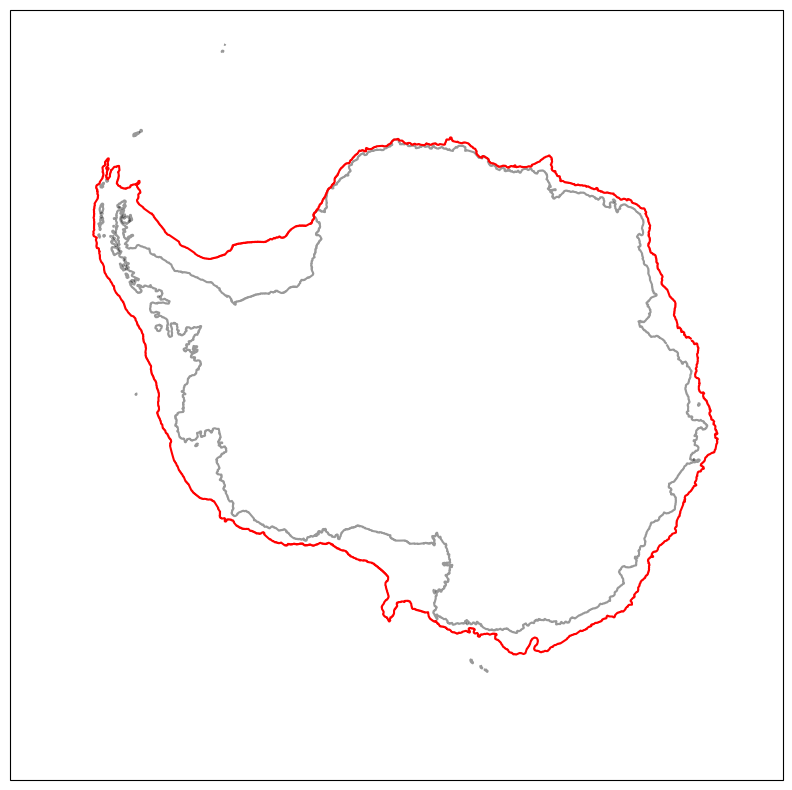

In [13]:
#Generating land and shelf mask
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)


fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

plt.show()

In [14]:
#Land mask for coloring the Antarctica in darkgrey
lat_slice = slice(-90, -59)
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', session=session, frequency='static', n=1)
hu = hu.sel(yu_ocean=lat_slice)

theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

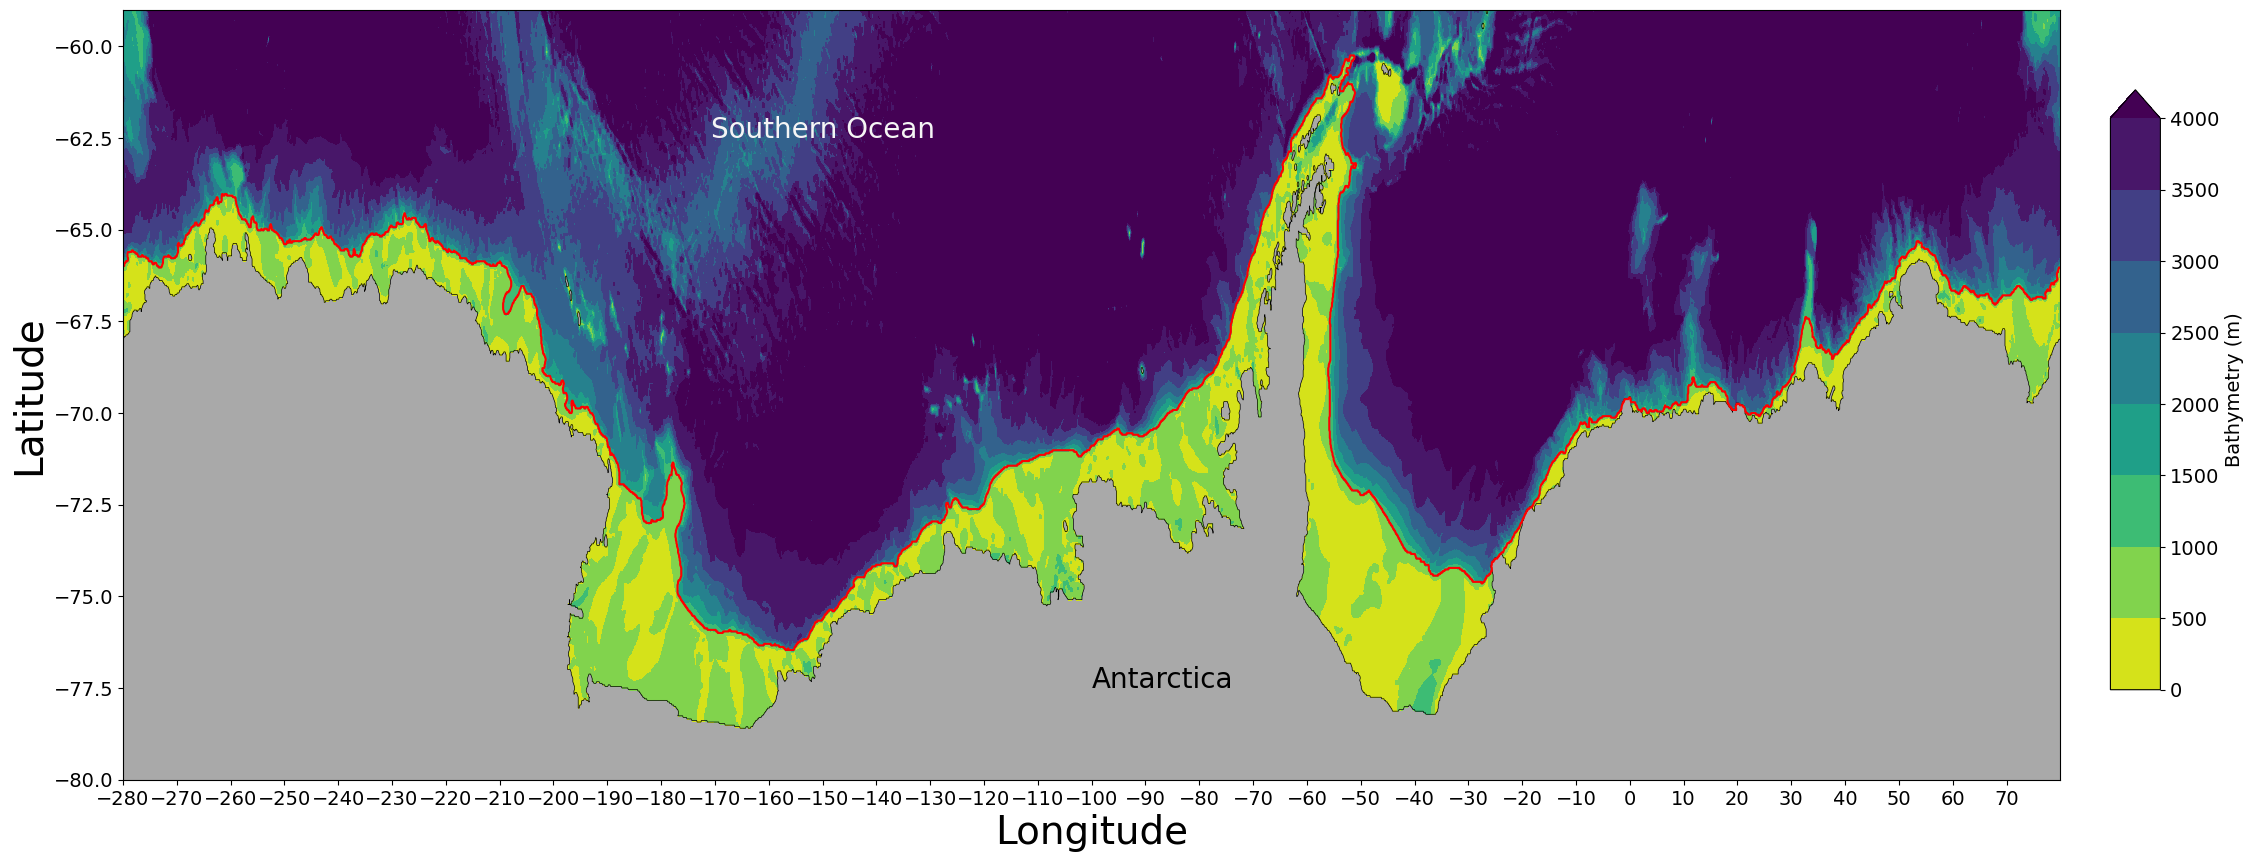

In [14]:
fig=plt.figure(2,(25,10))
ax = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-59)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]   
plot = ax.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')


ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'whitesmoke', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-59))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

plt.show()

## Experiment:	01deg_jra55v13_ryf9091

Description:	0.1 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat Year Forcing strategy outlined by Stewart et al. (2020), https://doi.org/10.1016/j.ocemod.2019.101557. The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. Run with JRA55-do v1.3 RYF9091 forcing. Spin up starts from a nominal year of 1 Jan 1900 and runs to 31 Dec 2100.

Notes:	Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1969 and 1 Jan 2086 to 31 Dec 2100

Contact:	Andy Hogg <andy.hogg@anu.edu.au>

No. files:	12671

Created:	2020-06-11

In [15]:
# Import variables from experiments, convert temperature to degree Celsius
temp_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00') - 273.15
salt_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
u_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='u', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
v_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='v', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_ryf = temp_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_ryf = salt_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_ryf = u_ryf.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_ryf = v_ryf.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# Make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. 
# This mask is used to delineate Antarctic continental regions.
ht_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)
ht_ryf = ht_ryf.sel(yt_ocean = slice(lat_min, lat_max)) # Select latitude range
land_mask_ryf_ht = ~ht_ryf.isnull()
shelf_mask_ryf_ht = (land_mask_ryf_ht.where(ht_ryf < 1000))

hu_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', session=session, frequency='static', n=1)
hu_ryf = hu_ryf.sel(yu_ocean = slice(lat_min, lat_max)) # Select latitude range
land_mask_ryf_hu = ~hu_ryf.isnull()
shelf_mask_ryf_hu = (land_mask_ryf_hu.where(hu_ryf < 1000))

# load in area for weighted average over areas
area_t_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t',  session=session, frequency='static', n=1)
area_t_ryf = area_t_ryf.sel(yt_ocean = slice(lat_min, lat_max))
area_t_ryf = area_t_ryf.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5), plus meltwater perturbation

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	410

Created:	2021-04-20

In [16]:
# Import variables from experiments, convert temperature to degree Celsius
temp_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00') - 273.15
salt_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
u_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='u', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
v_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='v', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthp = temp_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_wthp = salt_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_wthp = u_wthp.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_wthp = v_wthp.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# load in area for weighted average over areas
area_t_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthp = area_t_wthp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthp = area_t_wthp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5)

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	390

Created:	2021-04-20

In [17]:
# Import variables from experiments, convert temperature to degree Celsius
temp_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00') - 273.15
salt_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
u_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='u', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')
v_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='v', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthmp = temp_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_wthmp = salt_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_wthmp = u_wthmp.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_wthmp = v_wthmp.sel(yu_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2135-12-31 00:00:00')

# load in area for weighted average over areas
area_t_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthmp = area_t_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthmp = area_t_wthmp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Functions for selecting slices (Analysis Regions p2)

Different depth levels (slice at surface, 250m depth, sea floor and a weighted depth average) are selected to analyse the homogeneity of the changes in the vertical water column.

In [18]:
# Functions for selecting slice of different depths

# When using ht for shelf masking

# Select slice of ocean at surface and 250m depth:
def slice_depth(var_expt,st_depth):
    var_depth_expt = var_expt.sel(st_ocean=st_depth, method='nearest')
    var_depth_shelf_expt = var_depth_expt*shelf_mask_ryf_ht
    return var_depth_shelf_expt

# Select slice at sea floor:
def slice_bottom(var_expt):
    var_depth_array_expt = var_expt * 0 + var_expt.st_ocean # Array that has the depth levels
    var_max_depth_expt   = var_depth_array_expt.max(dim='st_ocean', skipna=True) # Get max depth of data (skipping nans)
    # Select the temp using max_depth
    # Bottom is where the depth level is larger/equal the max depth
    var_bottom_expt = var_expt.where(var_depth_array_expt.st_ocean >= var_max_depth_expt)
    var_bottom_expt = var_bottom_expt.sum(dim='st_ocean')
    var_bottom_shelf_expt = var_bottom_expt*shelf_mask_ryf_ht
    return var_bottom_shelf_expt

# Weighted average with all depths
def average_st(var_expt,st_edges_ocean_expt):
    thickness_values_expt = np.diff(st_edges_ocean_expt)
    thickness_expt = xr.DataArray(data=thickness_values_expt,dims=["st_ocean"],coords=dict(st_ocean=var_expt.st_ocean.values,),)
    #for coords, st_ocean=var.st_ocean.values.
    weights_st_expt = thickness_expt
    var_st_expt = var_expt.weighted(weights_st_expt).mean('st_ocean')
    var_st_shelf_expt = var_st_expt*shelf_mask_ryf_ht
    return var_st_shelf_expt

# When using hu for shelf masking

# Select slice of ocean at surface and 250m depth:
def slice_depth_hu(var_expt,st_depth):
    var_depth_expt = var_expt.sel(st_ocean=st_depth, method='nearest')
    var_depth_shelf_expt = var_depth_expt*shelf_mask_ryf_hu
    return var_depth_shelf_expt

# Select slice at sea floor:
def slice_bottom_hu(var_expt):
    var_depth_array_expt = var_expt * 0 + var_expt.st_ocean # Array that has the depth levels
    var_max_depth_expt   = var_depth_array_expt.max(dim='st_ocean', skipna=True) # Get max depth of data (skipping nans)
    # Select the temp using max_depth
    # Bottom is where the depth level is larger/equal the max depth
    var_bottom_expt = var_expt.where(var_depth_array_expt.st_ocean >= var_max_depth_expt)
    var_bottom_expt = var_bottom_expt.sum(dim='st_ocean')
    var_bottom_shelf_expt = var_bottom_expt*shelf_mask_ryf_hu
    return var_bottom_shelf_expt

# Weighted average with all depths
def average_st_hu(var_expt,st_edges_ocean_expt):
    thickness_values_expt = np.diff(st_edges_ocean_expt)
    thickness_expt = xr.DataArray(data=thickness_values_expt,dims=["st_ocean"],coords=dict(st_ocean=var_expt.st_ocean.values,),)
    #for coords, st_ocean=var.st_ocean.values.
    weights_st_expt = thickness_expt
    var_st_expt = var_expt.weighted(weights_st_expt).mean('st_ocean')
    var_st_shelf_expt = var_st_expt*shelf_mask_ryf_hu
    return var_st_shelf_expt

### Calculate slices of monthly and annual time series (Analysis Regions p3)

The temperature changes due to melting and warming perturbation individually could be calculated by subracting among ocean temperatures among different experiments. The temperature anomaly under melting is suggested by difference between WTHP and WTHMP experiments, while the temperature anomaly under warming is suggested by difference between WTHP and control experiments.

In [19]:
# Temperature and salinity

# Select slice of ocean at surface and 250m depth:
temp_surface_shelf_ryf = slice_depth(temp_ryf,0)
temp_surface_shelf_ryf_annual_mean = temp_surface_shelf_ryf.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf = slice_depth(salt_ryf,0)
salt_surface_shelf_ryf_annual_mean = salt_surface_shelf_ryf.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf = slice_depth(temp_ryf,250)
temp_250m_shelf_ryf_annual_mean = temp_250m_shelf_ryf.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf = slice_depth(salt_ryf,250)
salt_250m_shelf_ryf_annual_mean = temp_250m_shelf_ryf.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp = slice_depth(temp_wthp,0)
temp_surface_shelf_wthp_annual_mean = temp_surface_shelf_wthp.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp = slice_depth(salt_wthp,0)
salt_surface_shelf_wthp_annual_mean = salt_surface_shelf_wthp.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp = slice_depth(temp_wthp,250)
temp_250m_shelf_wthp_annual_mean = temp_250m_shelf_wthp.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp = slice_depth(salt_wthp,250)
salt_250m_shelf_wthp_annual_mean = salt_250m_shelf_wthp.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp = slice_depth(temp_wthmp,0)
temp_surface_shelf_wthmp_annual_mean = temp_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp = slice_depth(salt_wthmp,0)
salt_surface_shelf_wthmp_annual_mean = salt_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp = slice_depth(temp_wthmp,250)
temp_250m_shelf_wthmp_annual_mean = temp_250m_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp = slice_depth(salt_wthmp,250)
salt_250m_shelf_wthmp_annual_mean = salt_250m_shelf_wthmp.groupby('time.year').mean(dim='time')

# Select slice at sea floor:
temp_bottom_shelf_ryf = slice_bottom(temp_ryf)
temp_bottom_shelf_ryf_annual_mean = temp_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf = slice_bottom(salt_ryf)
salt_bottom_shelf_ryf_annual_mean = salt_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp = slice_bottom(temp_wthp)
temp_bottom_shelf_wthp_annual_mean = temp_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp = slice_bottom(salt_wthp)
salt_bottom_shelf_wthp_annual_mean = salt_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp = slice_bottom(temp_wthmp)
temp_bottom_shelf_wthmp_annual_mean = temp_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp = slice_bottom(salt_wthmp)
salt_bottom_shelf_wthmp_annual_mean = salt_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')

# Weighted average with all depths
temp_st_shelf_ryf = average_st(temp_ryf,st_edges_ocean_ryf)
temp_st_shelf_ryf_annual_mean = temp_st_shelf_ryf.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf = average_st(salt_ryf,st_edges_ocean_ryf)
salt_st_shelf_ryf_annual_mean = salt_st_shelf_ryf.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp = average_st(temp_wthp,st_edges_ocean_wthp)
temp_st_shelf_wthp_annual_mean = temp_st_shelf_wthp.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp = average_st(salt_wthp,st_edges_ocean_wthp)
salt_st_shelf_wthp_annual_mean = salt_st_shelf_wthp.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp = average_st(temp_wthmp,st_edges_ocean_wthmp)
temp_st_shelf_wthmp_annual_mean = temp_st_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp = average_st(salt_wthmp,st_edges_ocean_wthmp)
salt_st_shelf_wthmp_annual_mean = salt_st_shelf_wthmp.groupby('time.year').mean(dim='time')

# u & v

# Select slice of ocean at surface and 250m depth:
u_surface_shelf_ryf = slice_depth_hu(u_ryf,0)
u_surface_shelf_ryf_annual_mean = u_surface_shelf_ryf.groupby('time.year').mean(dim='time')
v_surface_shelf_ryf = slice_depth_hu(v_ryf,0)
v_surface_shelf_ryf_annual_mean = v_surface_shelf_ryf.groupby('time.year').mean(dim='time')
u_250m_shelf_ryf = slice_depth_hu(u_ryf,250)
u_250m_shelf_ryf_annual_mean = u_250m_shelf_ryf.groupby('time.year').mean(dim='time')
v_250m_shelf_ryf = slice_depth_hu(v_ryf,250)
v_250m_shelf_ryf_annual_mean = u_250m_shelf_ryf.groupby('time.year').mean(dim='time')
u_surface_shelf_wthp = slice_depth_hu(u_wthp,0)
u_surface_shelf_wthp_annual_mean = u_surface_shelf_wthp.groupby('time.year').mean(dim='time')
v_surface_shelf_wthp = slice_depth_hu(v_wthp,0)
v_surface_shelf_wthp_annual_mean = v_surface_shelf_wthp.groupby('time.year').mean(dim='time')
u_250m_shelf_wthp = slice_depth_hu(u_wthp,250)
u_250m_shelf_wthp_annual_mean = u_250m_shelf_wthp.groupby('time.year').mean(dim='time')
v_250m_shelf_wthp = slice_depth_hu(v_wthp,250)
v_250m_shelf_wthp_annual_mean = v_250m_shelf_wthp.groupby('time.year').mean(dim='time')
u_surface_shelf_wthmp = slice_depth_hu(u_wthmp,0)
u_surface_shelf_wthmp_annual_mean = u_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
v_surface_shelf_wthmp = slice_depth_hu(v_wthmp,0)
v_surface_shelf_wthmp_annual_mean = v_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
u_250m_shelf_wthmp = slice_depth_hu(u_wthmp,250)
u_250m_shelf_wthmp_annual_mean = u_250m_shelf_wthmp.groupby('time.year').mean(dim='time')
v_250m_shelf_wthmp = slice_depth_hu(v_wthmp,250)
v_250m_shelf_wthmp_annual_mean = v_250m_shelf_wthmp.groupby('time.year').mean(dim='time')

# Select slice at sea floor:
u_bottom_shelf_ryf = slice_bottom_hu(u_ryf)
u_bottom_shelf_ryf_annual_mean = u_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
v_bottom_shelf_ryf = slice_bottom_hu(v_ryf)
v_bottom_shelf_ryf_annual_mean = v_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
u_bottom_shelf_wthp = slice_bottom_hu(u_wthp)
u_bottom_shelf_wthp_annual_mean = u_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
v_bottom_shelf_wthp = slice_bottom_hu(v_wthp)
v_bottom_shelf_wthp_annual_mean = v_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
u_bottom_shelf_wthmp = slice_bottom_hu(u_wthmp)
u_bottom_shelf_wthmp_annual_mean = u_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')
v_bottom_shelf_wthmp = slice_bottom_hu(v_wthmp)
v_bottom_shelf_wthmp_annual_mean = v_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')

# Weighted average with all depths
u_st_shelf_ryf = average_st_hu(u_ryf,st_edges_ocean_ryf)
u_st_shelf_ryf_annual_mean = u_st_shelf_ryf.groupby('time.year').mean(dim='time')
v_st_shelf_ryf = average_st_hu(v_ryf,st_edges_ocean_ryf)
v_st_shelf_ryf_annual_mean = v_st_shelf_ryf.groupby('time.year').mean(dim='time')
u_st_shelf_wthp = average_st_hu(u_wthp,st_edges_ocean_wthp)
u_st_shelf_wthp_annual_mean = u_st_shelf_wthp.groupby('time.year').mean(dim='time')
v_st_shelf_wthp = average_st_hu(v_wthp,st_edges_ocean_wthp)
v_st_shelf_wthp_annual_mean = v_st_shelf_wthp.groupby('time.year').mean(dim='time')
u_st_shelf_wthmp = average_st_hu(u_wthmp,st_edges_ocean_wthmp)
u_st_shelf_wthmp_annual_mean = u_st_shelf_wthmp.groupby('time.year').mean(dim='time')
v_st_shelf_wthmp = average_st_hu(v_wthmp,st_edges_ocean_wthmp)
v_st_shelf_wthmp_annual_mean = v_st_shelf_wthmp.groupby('time.year').mean(dim='time')

In [20]:
# Experimental anomaly
temp_st_shelf_warmanom = (temp_st_shelf_wthp - temp_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_warmanom_annual_mean = temp_st_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_st_shelf_meltanom = (temp_st_shelf_wthmp - temp_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_meltanom_annual_mean = temp_st_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_st_shelf_warmmeltanom = (temp_st_shelf_wthmp - temp_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_warmmeltanom_annual_mean = temp_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_surface_shelf_warmanom = (temp_surface_shelf_wthp - temp_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_warmanom_annual_mean = temp_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_surface_shelf_meltanom = (temp_surface_shelf_wthmp - temp_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_meltanom_annual_mean = temp_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_surface_shelf_warmmeltanom = (temp_surface_shelf_wthmp - temp_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_warmmeltanom_annual_mean = temp_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_250m_shelf_warmanom = (temp_250m_shelf_wthp - temp_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_warmanom_annual_mean = temp_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_250m_shelf_meltanom = (temp_250m_shelf_wthmp - temp_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_meltanom_annual_mean = temp_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_250m_shelf_warmmeltanom = (temp_250m_shelf_wthmp - temp_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_warmmeltanom_annual_mean = temp_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_bottom_shelf_warmanom = (temp_bottom_shelf_wthp - temp_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_warmanom_annual_mean = temp_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_meltanom = (temp_bottom_shelf_wthmp - temp_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_meltanom_annual_mean = temp_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_warmmeltanom = (temp_bottom_shelf_wthmp - temp_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_warmmeltanom_annual_mean = temp_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_st_shelf_warmanom = (salt_st_shelf_wthp - salt_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_warmanom_annual_mean = salt_st_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_st_shelf_meltanom = (salt_st_shelf_wthmp - salt_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_meltanom_annual_mean = salt_st_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_st_shelf_warmmeltanom = (salt_st_shelf_wthmp - salt_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_warmmeltanom_annual_mean = salt_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_surface_shelf_warmanom = (salt_surface_shelf_wthp - salt_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_warmanom_annual_mean = salt_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_surface_shelf_meltanom = (salt_surface_shelf_wthmp - salt_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_meltanom_annual_mean = salt_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_surface_shelf_warmmeltanom = (salt_surface_shelf_wthmp - salt_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_warmmeltanom_annual_mean = salt_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_250m_shelf_warmanom = (salt_250m_shelf_wthp - salt_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_warmanom_annual_mean = salt_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_250m_shelf_meltanom = (salt_250m_shelf_wthmp - salt_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_meltanom_annual_mean = salt_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_250m_shelf_warmmeltanom = (salt_250m_shelf_wthmp - salt_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_warmmeltanom_annual_mean = salt_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_bottom_shelf_warmanom = (salt_bottom_shelf_wthp - salt_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_warmanom_annual_mean = salt_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_meltanom = (salt_bottom_shelf_wthmp - salt_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_meltanom_annual_mean = salt_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_warmmeltanom = (salt_bottom_shelf_wthmp - salt_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_warmmeltanom_annual_mean = salt_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

u_st_shelf_warmanom = (u_st_shelf_wthp - u_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_st_shelf_warmanom_annual_mean = u_st_shelf_warmanom.groupby('time.year').mean(dim='time')
u_st_shelf_meltanom = (u_st_shelf_wthmp - u_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_st_shelf_meltanom_annual_mean = u_st_shelf_meltanom.groupby('time.year').mean(dim='time')
u_st_shelf_warmmeltanom = (u_st_shelf_wthmp - u_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_st_shelf_warmmeltanom_annual_mean = u_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

u_surface_shelf_warmanom = (u_surface_shelf_wthp - u_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_surface_shelf_warmanom_annual_mean = u_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
u_surface_shelf_meltanom = (u_surface_shelf_wthmp - u_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_surface_shelf_meltanom_annual_mean = u_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
u_surface_shelf_warmmeltanom = (u_surface_shelf_wthmp - u_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_surface_shelf_warmmeltanom_annual_mean = u_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

u_250m_shelf_warmanom = (u_250m_shelf_wthp - u_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_250m_shelf_warmanom_annual_mean = u_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
u_250m_shelf_meltanom = (u_250m_shelf_wthmp - u_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_250m_shelf_meltanom_annual_mean = u_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
u_250m_shelf_warmmeltanom = (u_250m_shelf_wthmp - u_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_250m_shelf_warmmeltanom_annual_mean = u_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

u_bottom_shelf_warmanom = (u_bottom_shelf_wthp - u_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
u_bottom_shelf_warmanom_annual_mean = u_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
u_bottom_shelf_meltanom = (u_bottom_shelf_wthmp - u_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_bottom_shelf_meltanom_annual_mean = u_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
u_bottom_shelf_warmmeltanom = (u_bottom_shelf_wthmp - u_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
u_bottom_shelf_warmmeltanom_annual_mean = u_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

v_st_shelf_warmanom = (v_st_shelf_wthp - v_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_st_shelf_warmanom_annual_mean = v_st_shelf_warmanom.groupby('time.year').mean(dim='time')
v_st_shelf_meltanom = (v_st_shelf_wthmp - v_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_st_shelf_meltanom_annual_mean = v_st_shelf_meltanom.groupby('time.year').mean(dim='time')
v_st_shelf_warmmeltanom = (v_st_shelf_wthmp - v_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_st_shelf_warmmeltanom_annual_mean = v_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

v_surface_shelf_warmanom = (v_surface_shelf_wthp - v_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_surface_shelf_warmanom_annual_mean = v_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
v_surface_shelf_meltanom = (v_surface_shelf_wthmp - v_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_surface_shelf_meltanom_annual_mean = v_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
v_surface_shelf_warmmeltanom = (v_surface_shelf_wthmp - v_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_surface_shelf_warmmeltanom_annual_mean = v_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

v_250m_shelf_warmanom = (v_250m_shelf_wthp - v_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_250m_shelf_warmanom_annual_mean = v_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
v_250m_shelf_meltanom = (v_250m_shelf_wthmp - v_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_250m_shelf_meltanom_annual_mean = v_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
v_250m_shelf_warmmeltanom = (v_250m_shelf_wthmp - v_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_250m_shelf_warmmeltanom_annual_mean = v_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

v_bottom_shelf_warmanom = (v_bottom_shelf_wthp - v_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
v_bottom_shelf_warmanom_annual_mean = v_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
v_bottom_shelf_meltanom = (v_bottom_shelf_wthmp - v_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_bottom_shelf_meltanom_annual_mean = v_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
v_bottom_shelf_warmmeltanom = (v_bottom_shelf_wthmp - v_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
v_bottom_shelf_warmmeltanom_annual_mean = v_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

# Average over Antarctic shelf region

In [22]:
#Average over Antarctic shelf region
temp_st_shelf_warmanom_Antar_weights = temp_st_shelf_warmanom.weighted(area_t_ryf)
temp_st_shelf_warmanom_Antar = temp_st_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_warmanom_Antar_annual_mean = temp_st_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
temp_st_shelf_meltanom_Antar_weights = temp_st_shelf_meltanom.weighted(area_t_ryf)
temp_st_shelf_meltanom_Antar = temp_st_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_meltanom_Antar_annual_mean = temp_st_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
temp_st_shelf_warmmeltanom_Antar_weights = temp_st_shelf_warmmeltanom.weighted(area_t_ryf)
temp_st_shelf_warmmeltanom_Antar = temp_st_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_st_shelf_warmmeltanom_Antar_annual_mean = temp_st_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

temp_surface_shelf_warmanom_Antar_weights = temp_surface_shelf_warmanom.weighted(area_t_ryf)
temp_surface_shelf_warmanom_Antar = temp_surface_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_warmanom_Antar_annual_mean = temp_surface_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
temp_surface_shelf_meltanom_Antar_weights = temp_surface_shelf_meltanom.weighted(area_t_ryf)
temp_surface_shelf_meltanom_Antar = temp_surface_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_meltanom_Antar_annual_mean = temp_surface_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
temp_surface_shelf_warmmeltanom_Antar_weights = temp_surface_shelf_warmmeltanom.weighted(area_t_ryf)
temp_surface_shelf_warmmeltanom_Antar = temp_surface_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_surface_shelf_warmmeltanom_Antar_annual_mean = temp_surface_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

temp_250m_shelf_warmanom_Antar_weights = temp_250m_shelf_warmanom.weighted(area_t_ryf)
temp_250m_shelf_warmanom_Antar = temp_250m_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_warmanom_Antar_annual_mean = temp_250m_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
temp_250m_shelf_meltanom_Antar_weights = temp_250m_shelf_meltanom.weighted(area_t_ryf)
temp_250m_shelf_meltanom_Antar = temp_250m_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_meltanom_Antar_annual_mean = temp_250m_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
temp_250m_shelf_warmmeltanom_Antar_weights = temp_250m_shelf_warmmeltanom.weighted(area_t_ryf)
temp_250m_shelf_warmmeltanom_Antar = temp_250m_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_250m_shelf_warmmeltanom_Antar_annual_mean = temp_250m_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

temp_bottom_shelf_warmanom_Antar_weights = temp_bottom_shelf_warmanom.weighted(area_t_ryf)
temp_bottom_shelf_warmanom_Antar = temp_bottom_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_warmanom_Antar_annual_mean = temp_bottom_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
temp_bottom_shelf_meltanom_Antar_weights = temp_bottom_shelf_meltanom.weighted(area_t_ryf)
temp_bottom_shelf_meltanom_Antar = temp_bottom_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_meltanom_Antar_annual_mean = temp_bottom_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
temp_bottom_shelf_warmmeltanom_Antar_weights = temp_bottom_shelf_warmmeltanom.weighted(area_t_ryf)
temp_bottom_shelf_warmmeltanom_Antar = temp_bottom_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
temp_bottom_shelf_warmmeltanom_Antar_annual_mean = temp_bottom_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

salt_st_shelf_warmanom_Antar_weights = salt_st_shelf_warmanom.weighted(area_t_ryf)
salt_st_shelf_warmanom_Antar = salt_st_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_warmanom_Antar_annual_mean = salt_st_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
salt_st_shelf_meltanom_Antar_weights = salt_st_shelf_meltanom.weighted(area_t_ryf)
salt_st_shelf_meltanom_Antar = salt_st_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_meltanom_Antar_annual_mean = salt_st_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
salt_st_shelf_warmmeltanom_Antar_weights = salt_st_shelf_warmmeltanom.weighted(area_t_ryf)
salt_st_shelf_warmmeltanom_Antar = salt_st_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_st_shelf_warmmeltanom_Antar_annual_mean = salt_st_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

salt_surface_shelf_warmanom_Antar_weights = salt_surface_shelf_warmanom.weighted(area_t_ryf)
salt_surface_shelf_warmanom_Antar = salt_surface_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_warmanom_Antar_annual_mean = salt_surface_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
salt_surface_shelf_meltanom_Antar_weights = salt_surface_shelf_meltanom.weighted(area_t_ryf)
salt_surface_shelf_meltanom_Antar = salt_surface_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_meltanom_Antar_annual_mean = salt_surface_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
salt_surface_shelf_warmmeltanom_Antar_weights = salt_surface_shelf_warmmeltanom.weighted(area_t_ryf)
salt_surface_shelf_warmmeltanom_Antar = salt_surface_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_surface_shelf_warmmeltanom_Antar_annual_mean = salt_surface_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

salt_250m_shelf_warmanom_Antar_weights = salt_250m_shelf_warmanom.weighted(area_t_ryf)
salt_250m_shelf_warmanom_Antar = salt_250m_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_warmanom_Antar_annual_mean = salt_250m_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
salt_250m_shelf_meltanom_Antar_weights = salt_250m_shelf_meltanom.weighted(area_t_ryf)
salt_250m_shelf_meltanom_Antar = salt_250m_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_meltanom_Antar_annual_mean = salt_250m_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
salt_250m_shelf_warmmeltanom_Antar_weights = salt_250m_shelf_warmmeltanom.weighted(area_t_ryf)
salt_250m_shelf_warmmeltanom_Antar = salt_250m_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_250m_shelf_warmmeltanom_Antar_annual_mean = salt_250m_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

salt_bottom_shelf_warmanom_Antar_weights = salt_bottom_shelf_warmanom.weighted(area_t_ryf)
salt_bottom_shelf_warmanom_Antar = salt_bottom_shelf_warmanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_warmanom_Anta_annual_meanr = salt_bottom_shelf_warmanom_Antar.groupby('time.year').mean(dim='time')
salt_bottom_shelf_meltanom_Antar_weights = salt_bottom_shelf_meltanom.weighted(area_t_ryf)
salt_bottom_shelf_meltanom_Antar = salt_bottom_shelf_meltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_meltanom_Antar_annual_mean = salt_bottom_shelf_meltanom_Antar.groupby('time.year').mean(dim='time')
salt_bottom_shelf_warmmeltanom_Antar_weights = salt_bottom_shelf_warmmeltanom.weighted(area_t_ryf)
salt_bottom_shelf_warmmeltanom_Antar = salt_bottom_shelf_warmmeltanom_Antar_weights.mean(("xt_ocean", "yt_ocean"))
salt_bottom_shelf_warmmeltanom_Antar_annual_mean = salt_bottom_shelf_warmmeltanom_Antar.groupby('time.year').mean(dim='time')

In [23]:
temp_st_shelf_warmanom_Antar

<xarray.DataArray (time: 432)>
dask.array<truediv, shape=(432,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2100-01-16 12:00:00 ... 2135-12-16 12:00:00

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of Antarctic shelf region', fontsize=20)

#Plotting shelf temperature averaging over all depths
plt.subplot(4,2,1)
temp_st_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
temp_st_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
temp_st_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name1, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name1, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf salinity averaging over all depths
plt.subplot(4,2,2)
salt_st_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
salt_st_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
salt_st_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name2, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name2, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)

#Plotting shelf temperature at surface
plt.subplot(4,2,3)
temp_surface_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
temp_surface_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
temp_surface_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name3, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name3, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf salinity averaging at surface
plt.subplot(4,2,4)
salt_surface_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
salt_surface_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
salt_surface_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name4, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name4, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf temperature at 250m depth
plt.subplot(4,2,5)
temp_250m_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
temp_250m_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
temp_250m_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name5, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name5, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf salinity averaging at 250m depth
plt.subplot(4,2,6)
salt_250m_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
salt_250m_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
salt_250m_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name6, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name6, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf temperature at bottom
plt.subplot(4,2,7)
temp_bottom_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
temp_bottom_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
temp_bottom_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name7, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name7, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)
    
#Plotting shelf salinity averaging at bottom
plt.subplot(4,2,8)
salt_bottom_shelf_warmanom_Antar.sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
salt_bottom_shelf_meltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
salt_bottom_shelf_warmmeltanom_Antar.sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
plt.title(title_name8, fontsize=13, loc='center')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel(ylabel_name8, fontsize=12)
plt.legend(frameon=False, loc='upper center', ncol=3)

plt.show()

# Circumpolar annual experimental anomaly shelf region map

## Seasonal averages

The seasonal mean of temperature anomaly under melting averaging over the last 10 experimental years is calculated and all plotted to identify if seasonality has a strong influence on the thermal changes. The results suggest that only the temperature at surface shows stronger changes, while ocean temperature at other depths and averaged over all depths exhibit little difference among seasons, which is mainly due to the sea ice cover in other seasons except for summer. Therefore, the annual averaged time series could be used for this study.

In [23]:
# Function for making circumpolar map for seasonal data:

# Remember to define the levels for the contourf first
# Example: lvls = np.arange(-0.4,0.425,0.025)

def seasonal_circumpolar_plotting(var_depth_shelf):
    var_depth_shelf_last5yrs = var_depth_shelf.sel(time=slice('2131-01-01 00:00:00','2135-12-31 00:00:00'))
    var_depth_shelf_last5yrs_seasonal = var_depth_shelf_last5yrs.groupby('time.season').mean(dim='time')
    
    #var_depth_shelf_DJF = var_depth_shelf_seasonal[0,:,:]
    #var_depth_shelf_JJA = var_depth_shelf_seasonal[1,:,:]
    #var_depth_shelf_MAM = var_depth_shelf_seasonal[2,:,:]
    #var_depth_shelf_SON = var_depth_shelf_seasonal[3,:,:]
    
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5 #By changing the radius value (last one which is 0.5) you can control the size of the circle that is plotted
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(1, figsize=(8,8))   
    
    seasons_array = np.array(['DJF', 'JJA', 'MAM', 'SON'])
    
    for ii in range(4):
        ax = plt.subplot(2,2,1+ii, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
    
        # Plot land in grey
        ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        # Plot coastline in black
        ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot shelf region line
        ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red', linewidths = 0.5, transform=ccrs.PlateCarree())
        
        # Plot the shelf region
        cf = ax.contourf(var_depth_shelf_last5yrs_seasonal[ii,:,:]['xt_ocean'], 
                  var_depth_shelf_last5yrs_seasonal[ii,:,:]['yt_ocean'], 
                  var_depth_shelf_last5yrs_seasonal[ii,:,:], levels = lvls, cmap=cm.cm.balance, 
                  extend = 'both', transform = ccrs.PlateCarree())
        plt.title(seasons_array[ii], fontsize=16, loc='center')

    # Add colorbar
    ax = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(cf, cax=ax, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')
    
    plt.show()

## Temperature changes under only melting

### Seasonal shelf temperature changes averaging over all depths under melting

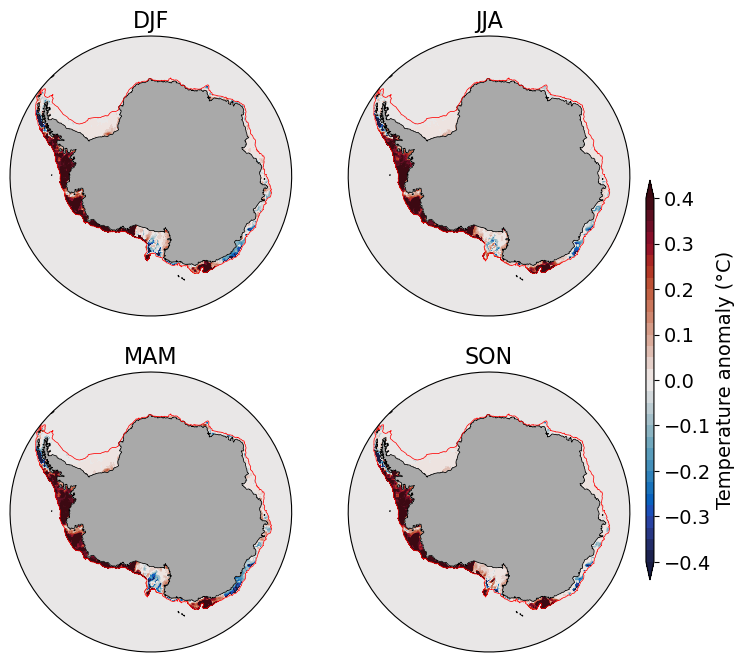

In [62]:
lvls = np.arange(-0.4,0.425,0.025)
seasonal_circumpolar_plotting(temp_st_shelf_meltanom)

### Seasonal shelf temperature changes at surface under melting

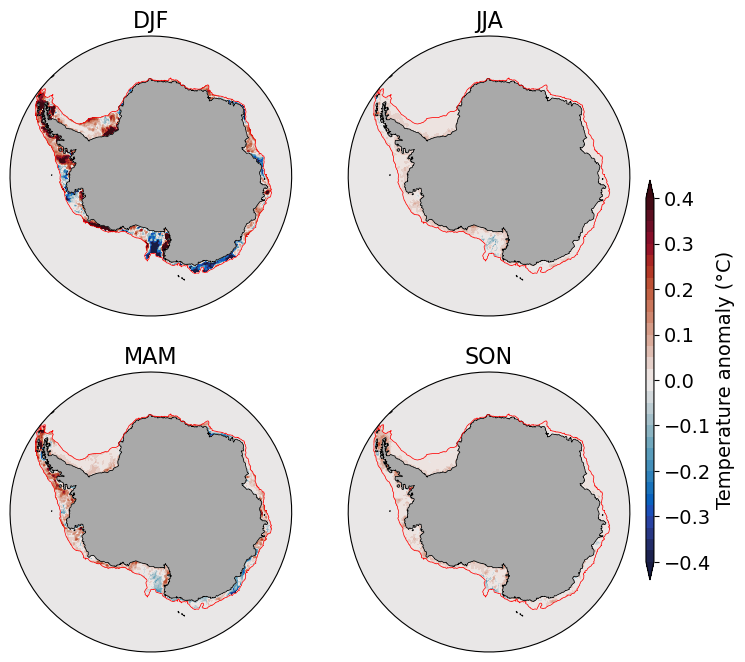

In [63]:
lvls = np.arange(-0.4,0.425,0.025)
seasonal_circumpolar_plotting(temp_surface_shelf_meltanom)

### Seasonal shelf temperature changes at 250m depth under melting

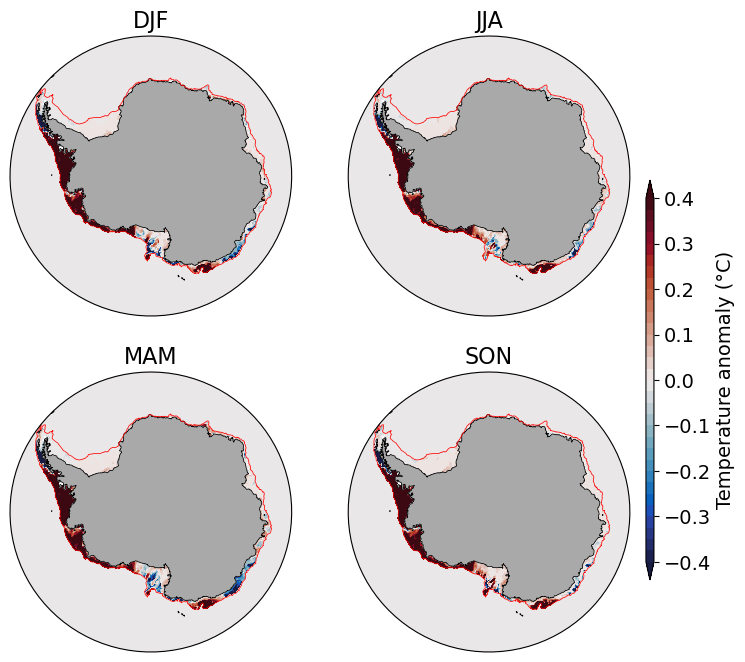

In [64]:
lvls = np.arange(-0.4,0.425,0.025)
seasonal_circumpolar_plotting(temp_250m_shelf_meltanom)

### Seasonal shelf temperature changes at bottom under melting

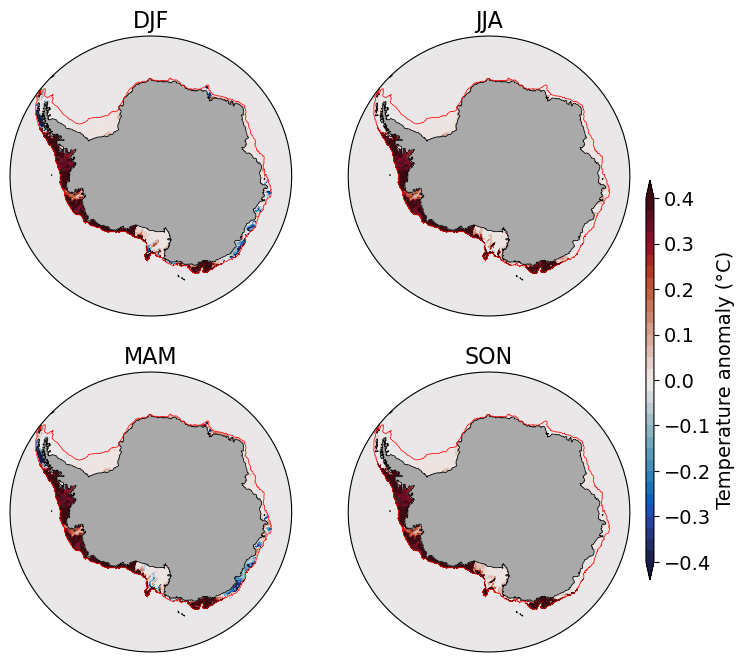

In [65]:
lvls = np.arange(-0.4,0.425,0.025)
seasonal_circumpolar_plotting(temp_bottom_shelf_meltanom)

The cooling in the wDDU region is the weakest just after Austral winter (the right 2 figures), which indicates melting in summer may cause more notable cooling effect at 250m depth and bottom in wDDU shelf region. At bottom depth, the peak of WAP region also suggests much weaker cooling effect during winter and spring, which might be due to the cold summer ice meltwater flowing from Larsen shelves and Weddell Sea.

## Annual averages

In [21]:
# Function for making circumpolar map for annual data:

# Remember to define the levels for the contourf first
# Example: lvls = np.arange(-0.4,0.425,0.025)

def annual_circumpolar_plotting(var_depth_shelf_annual_mean):
    
    var_depth_shelf_annual_mean = var_depth_shelf_annual_mean.sel(year=slice('2110','2135'))
    
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5 #By changing the radius value (last one which is 0.5) you can control the size of the circle that is plotted
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    fig = plt.figure(1, figsize=(15,15))   
    
    years_array = np.array(['2110', '2113', '2116', '2119', '2122', '2125', '2128', '2131', '2134'])
    
    for ii in range(9):
        ax = plt.subplot(3,3,1+ii, projection=ccrs.SouthPolarStereo())
        ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())
        ax.set_boundary(circle, transform=ax.transAxes)
    
        # Plot land in grey
        ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
        # Plot coastline in black
        ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
        # Plot shelf region line
        ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red', linewidths = 0.5, transform=ccrs.PlateCarree())

        # Plot the shelf region
        cf = ax.contourf(var_depth_shelf_annual_mean.isel(year = ii*3)['xt_ocean'], 
                  var_depth_shelf_annual_mean.isel(year = ii*3)['yt_ocean'], 
                  var_depth_shelf_annual_mean.isel(year = ii*3), levels = lvls, cmap=cm.cm.balance, 
                  extend = 'both', transform = ccrs.PlateCarree())
        plt.title(years_array[ii], fontsize=16, loc='center')

    # Add colorbar
    ax = plt.axes([0.92, 0.2, 0.01, 0.5])
    cb = plt.colorbar(cf, cax=ax, orientation='vertical')
    cb.ax.set_ylabel('Temperature anomaly (°C)')
    
    plt.show()

## WTHP as control experiment for melting effect

### Annual shelf temperature changes averaging over all depths of control experiment

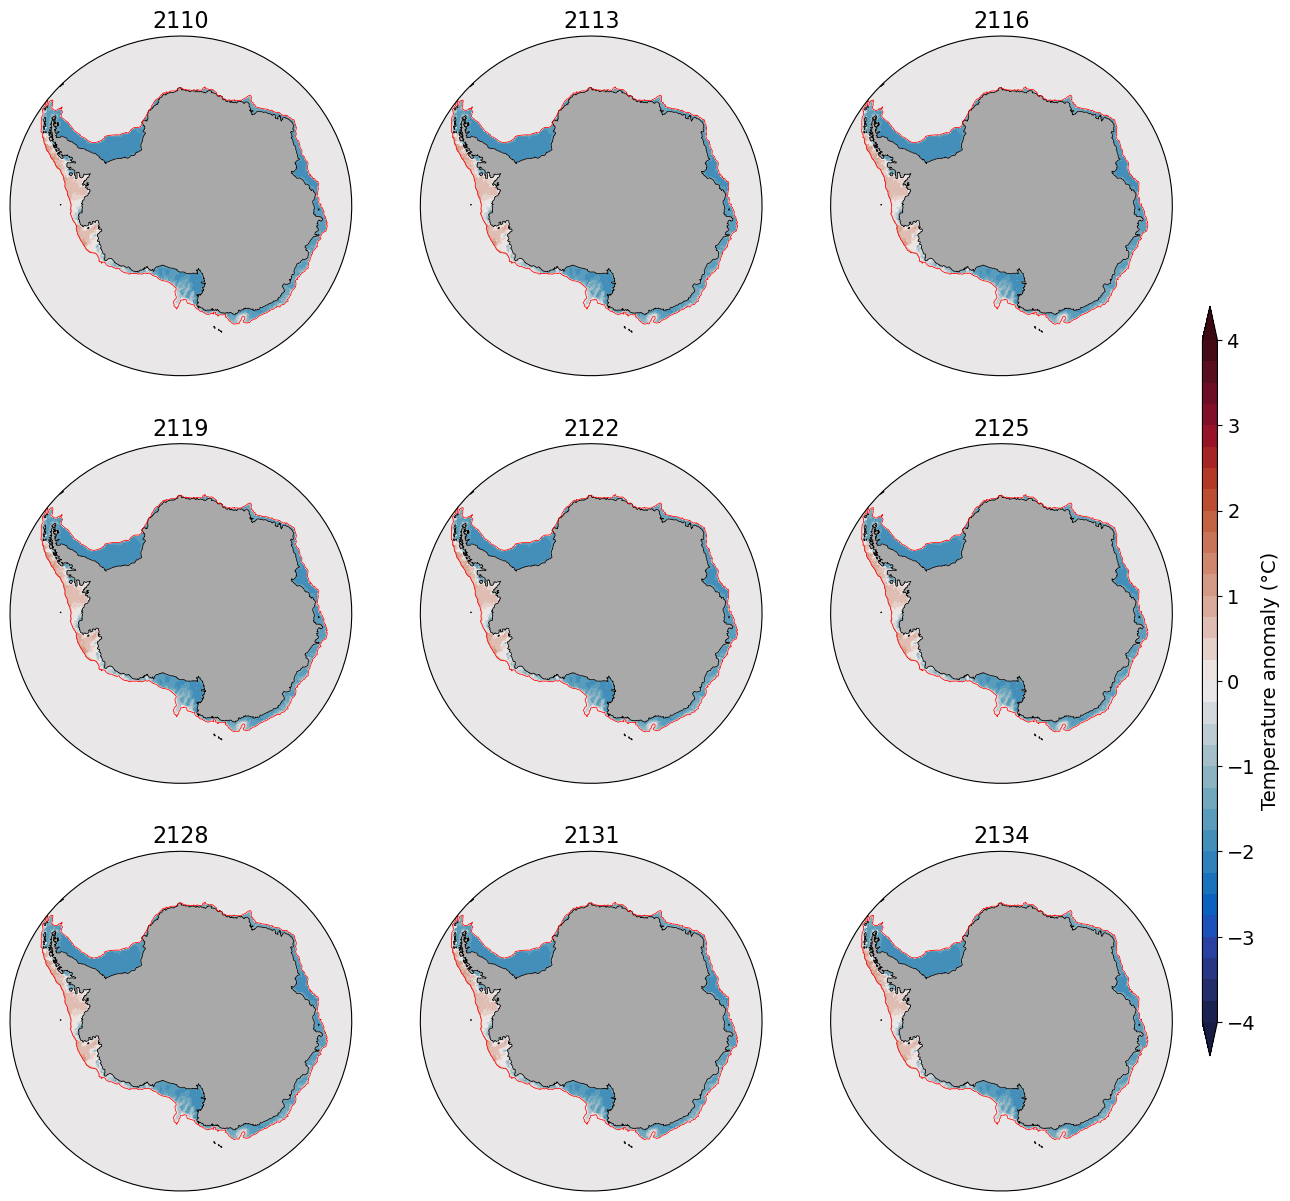

In [25]:
lvls = np.arange(-4,4.25,0.25)
annual_circumpolar_plotting(temp_st_shelf_wthp_annual_mean)

### Annual shelf temperature at surface of control experiments

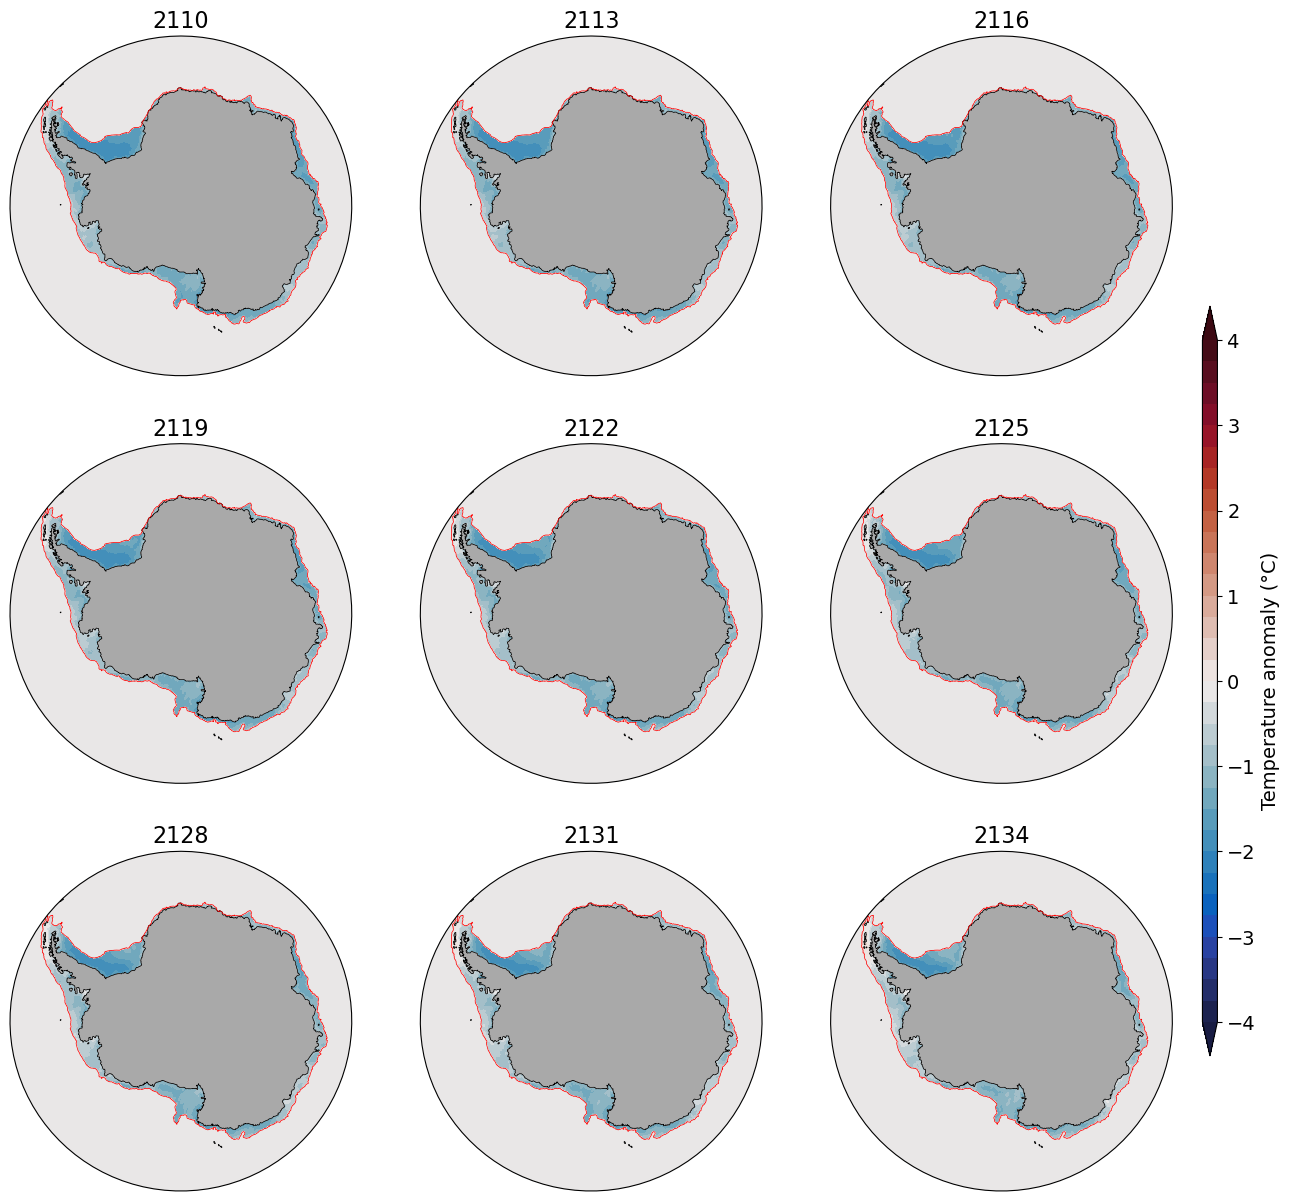

In [26]:
lvls = np.arange(-4,4.25,0.25)
annual_circumpolar_plotting(temp_surface_shelf_wthp_annual_mean)

### Annual shelf temperature at 250m depth of control experiments

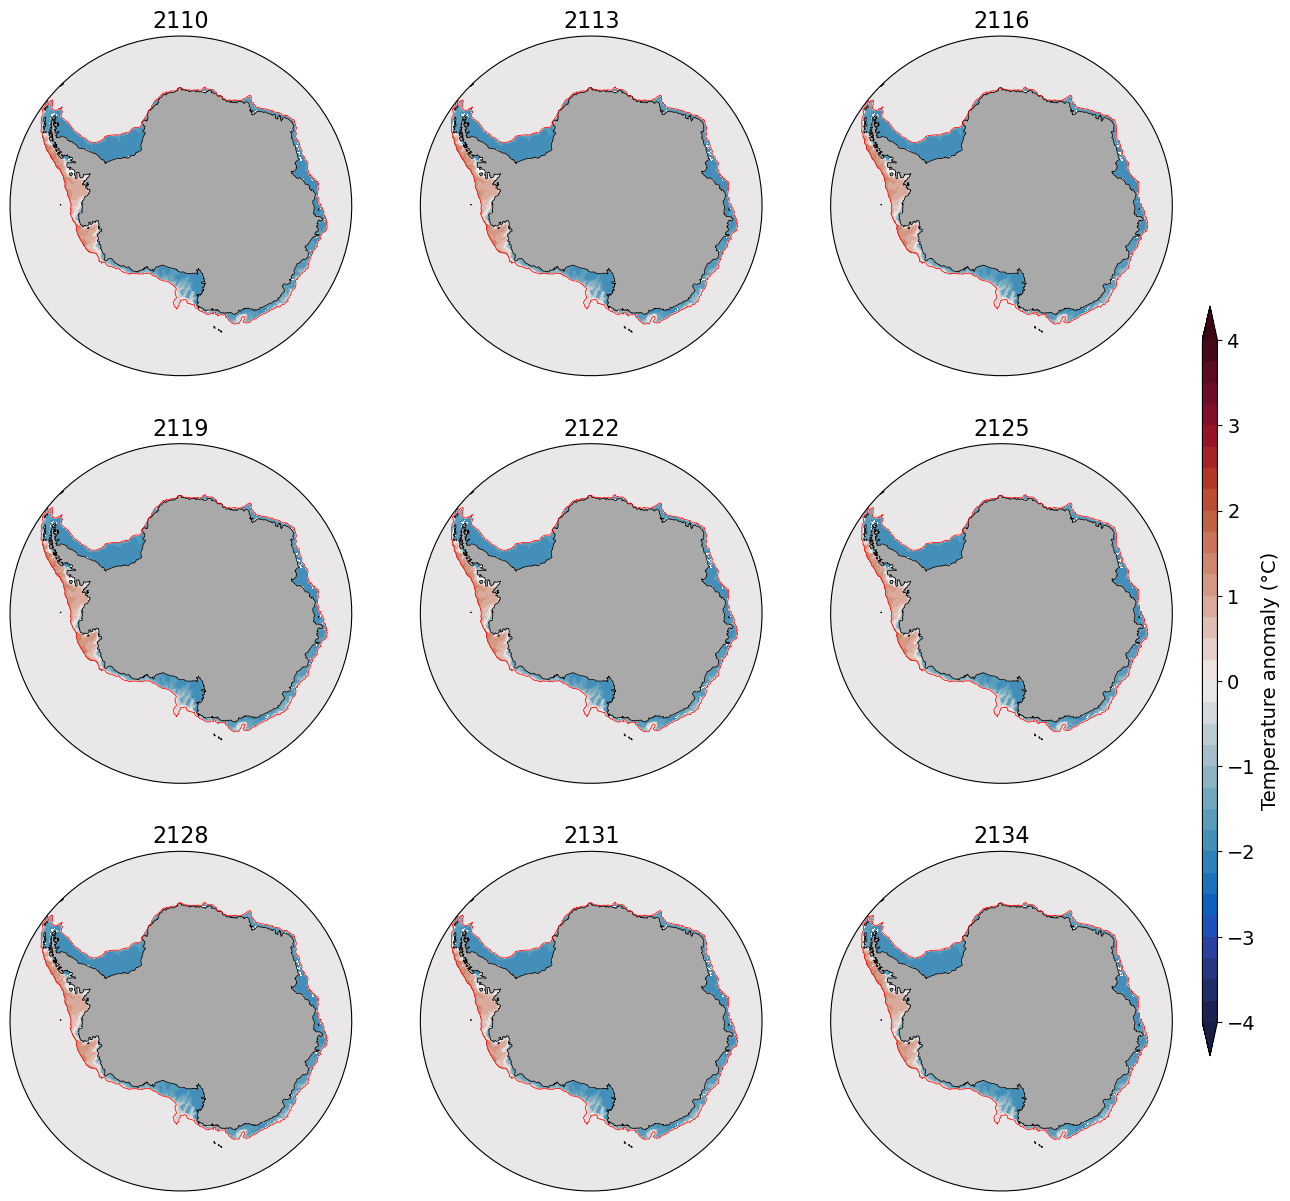

In [27]:
lvls = np.arange(-4,4.25,0.25)
annual_circumpolar_plotting(temp_250m_shelf_wthp_annual_mean)

### Annual shelf temperature at bottom of control experiments

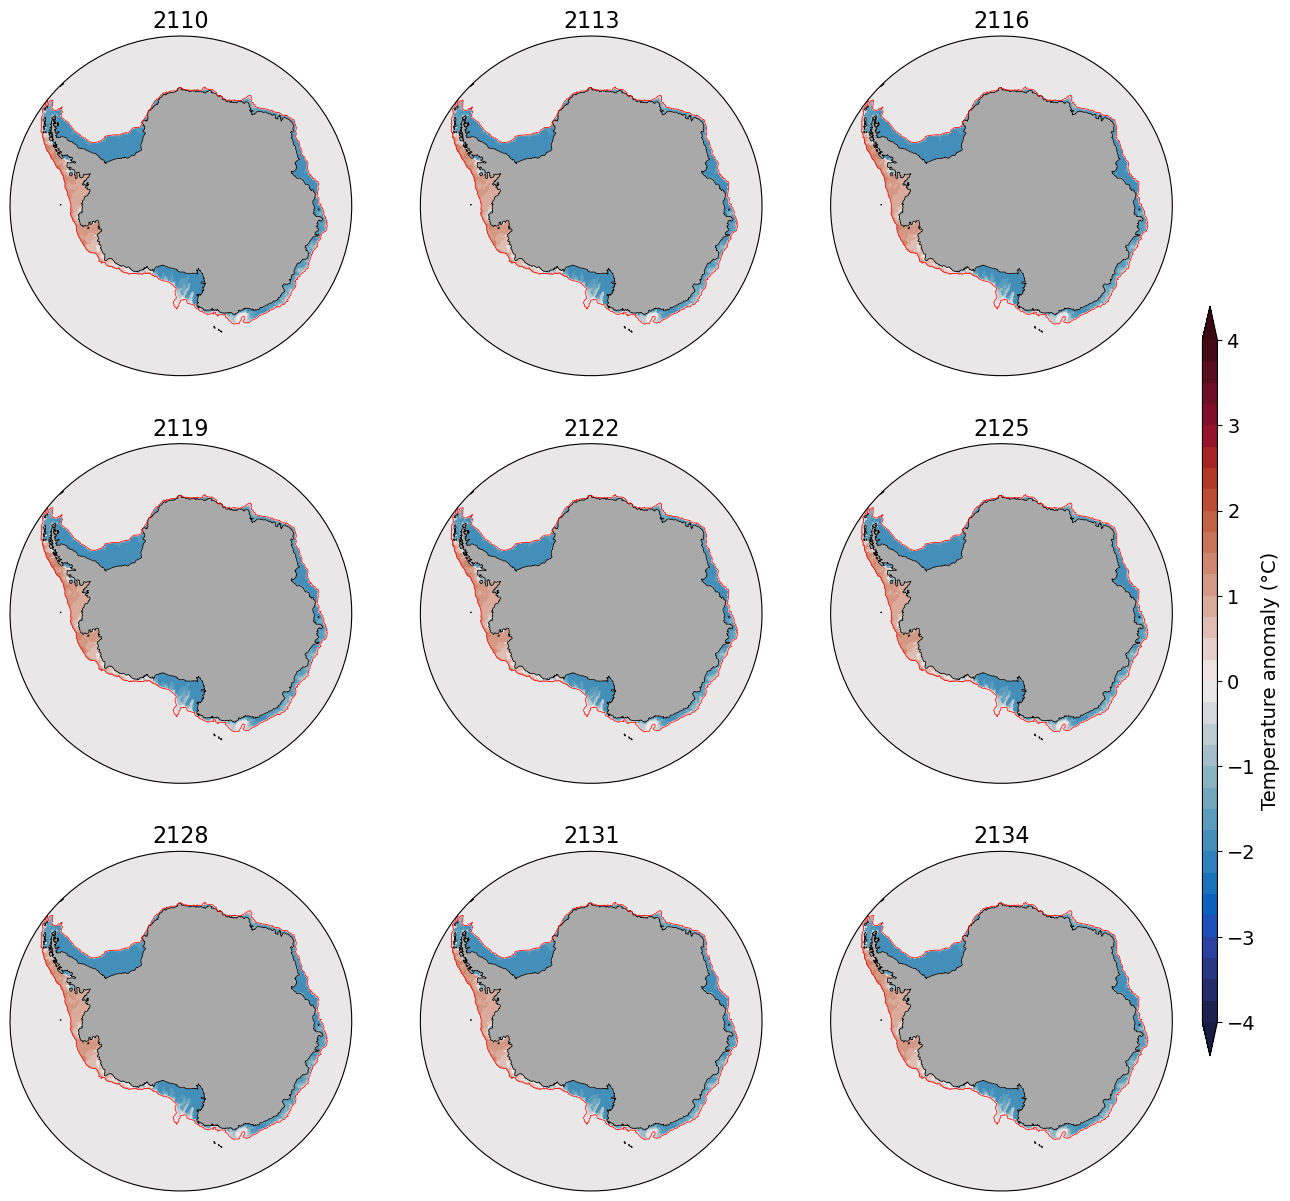

In [28]:
lvls = np.arange(-4,4.25,0.25)
annual_circumpolar_plotting(temp_bottom_shelf_wthp_annual_mean)

## Temperature changes under only melting

To exhibit temperature changes as the experiment carried on, the circumpolar map of shelf temperature anomaly under melting is plotted every three year. The temperature anomaly at 250m depth experienced much stronger changes than at surface and bottom.

### Annual shelf temperature changes averaging over all depths under melting

The earliest thermal changes, which is the warming at peak of WAP, could attribute to the initial warming forcing of the experiment at lower latitudes. This region, however, experienced strong cooling later on. Then the early strong warming happens at the crossing point of AB and eRoss region, which then propogates this warming signal along the coast eastwards until reaching the peak of WAP where the cooling gets stronger. This could be just due to the time it takes to have changes. wDDU also suggests a growing cooling signal propogating westward. wRoss and eDDU are experiencing opposite temperature changes and keep getting stronger as the year goes by, while the strongest temperature changes still happens in AB region.

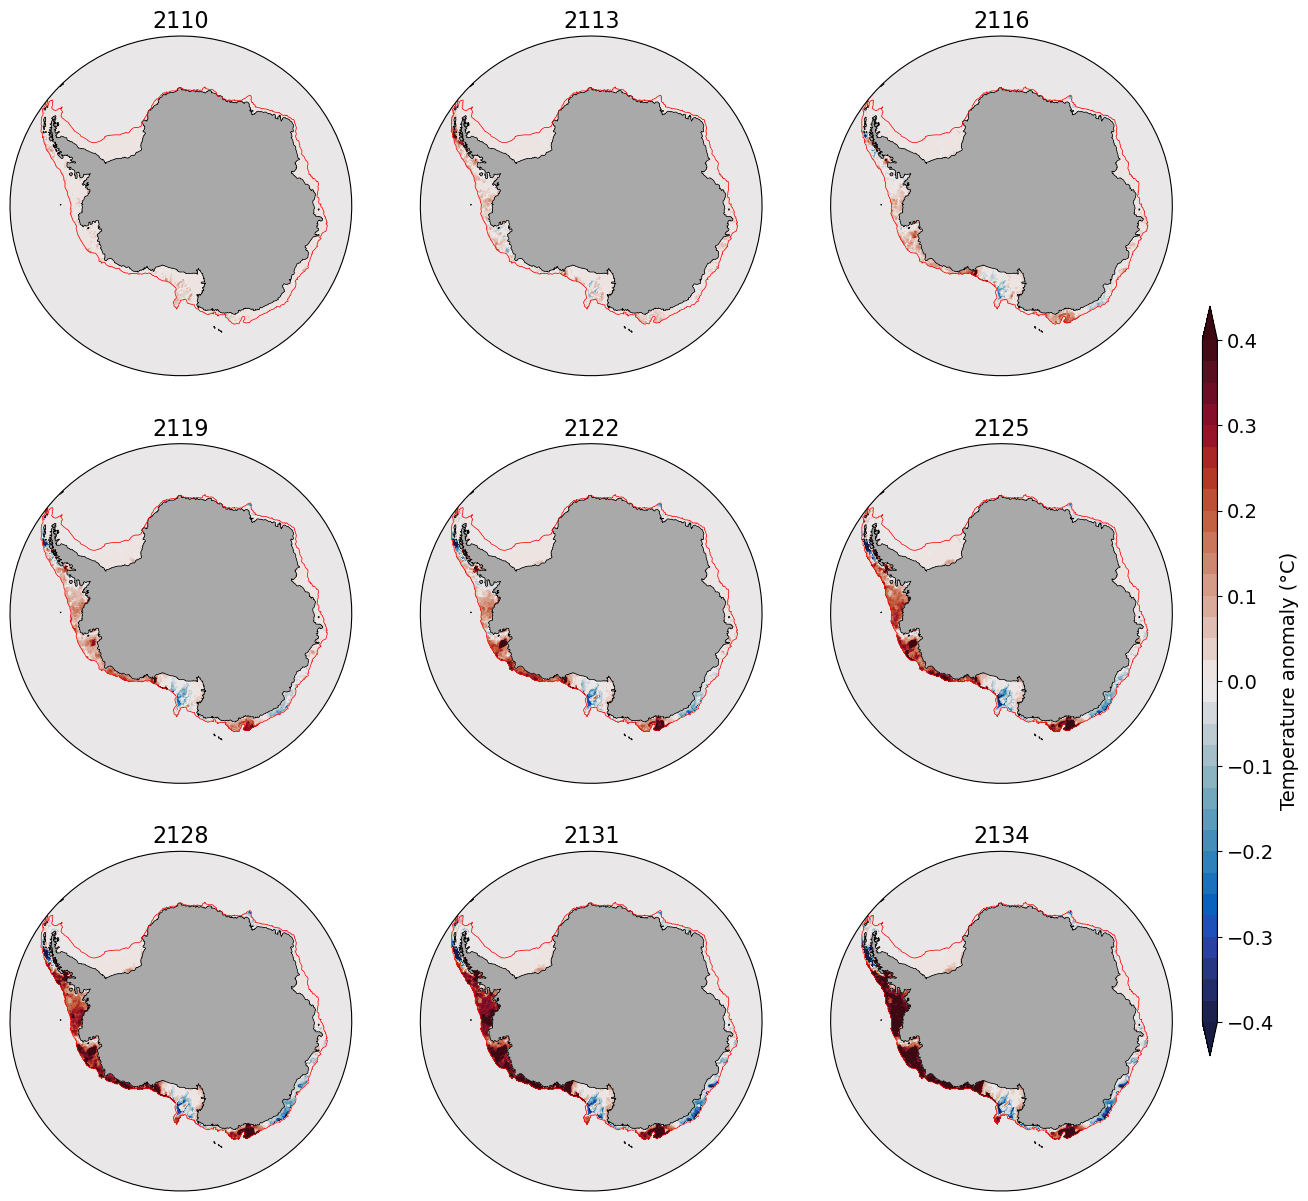

In [30]:
lvls = np.arange(-0.4,0.425,0.025)
annual_circumpolar_plotting(temp_st_shelf_meltanom_annual_mean)

### Annual shelf temperature changes at surface under melting

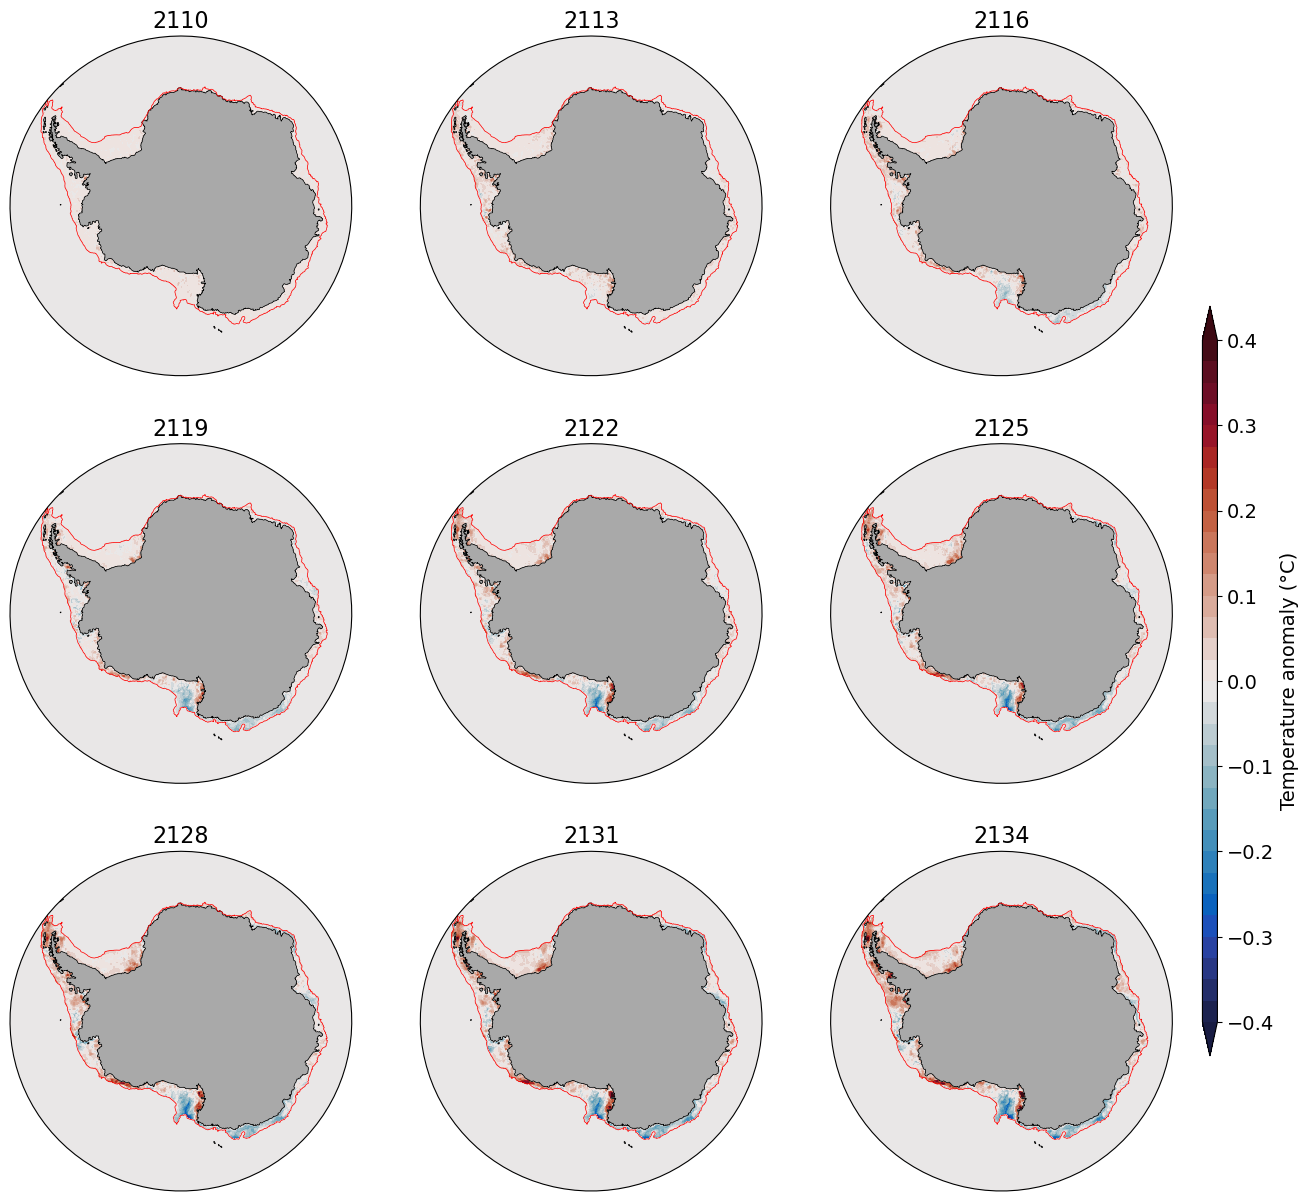

In [31]:
lvls = np.arange(-0.4,0.425,0.025)
annual_circumpolar_plotting(temp_surface_shelf_meltanom_annual_mean)

### Annual shelf temperature changes at 250m depth under melting

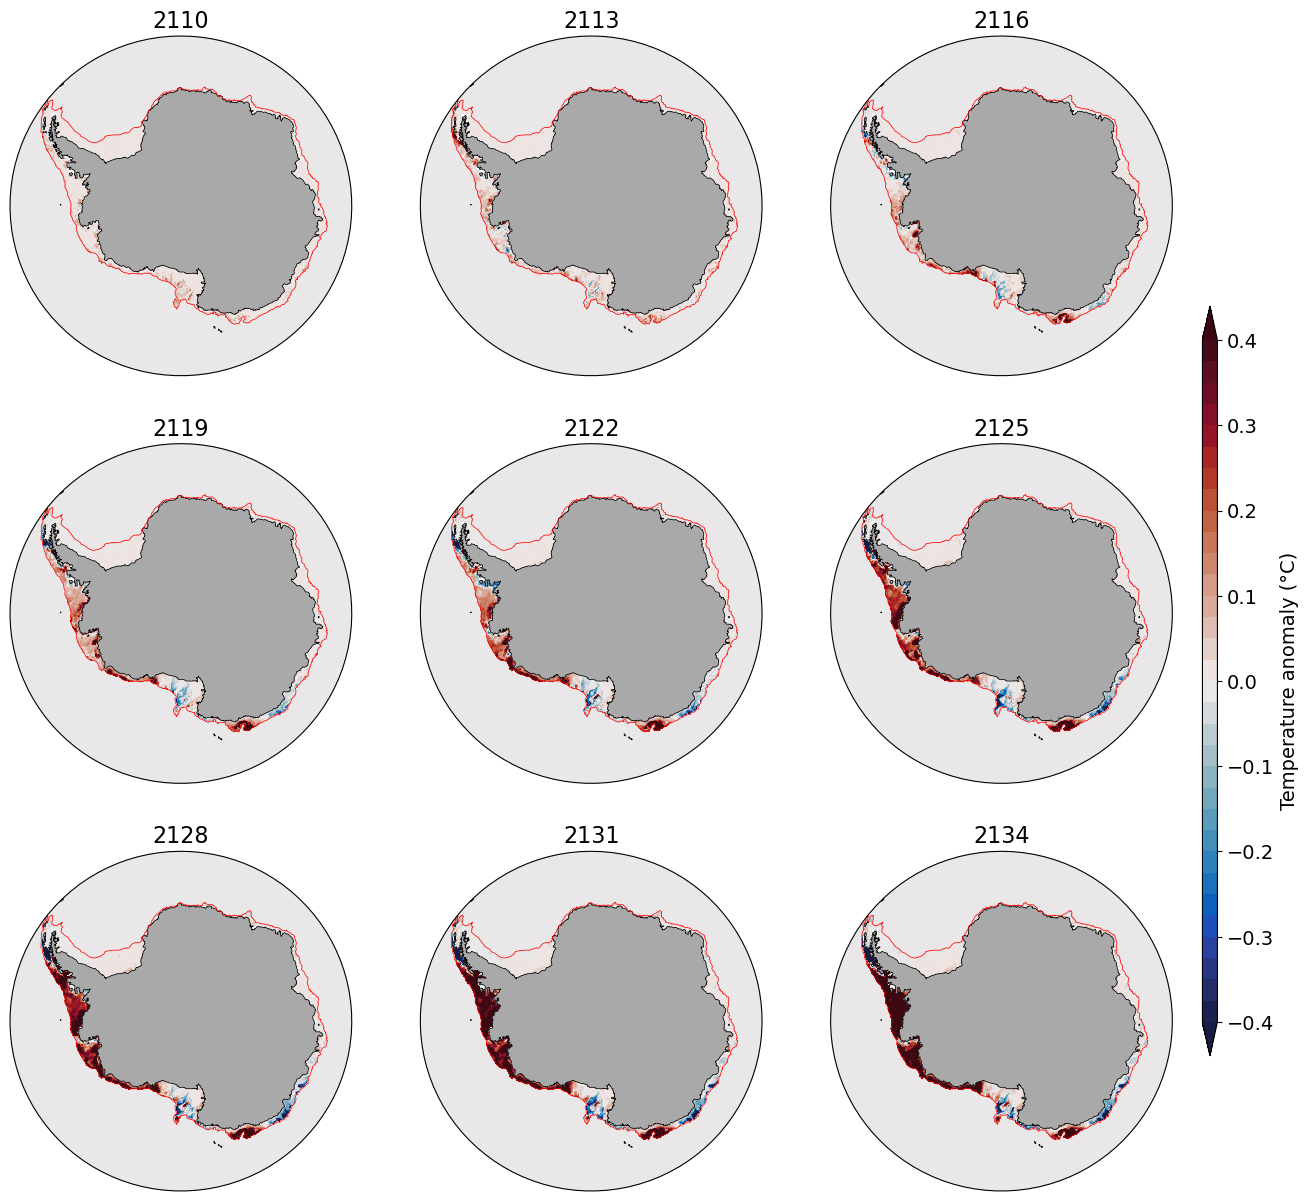

In [32]:
lvls = np.arange(-0.4,0.425,0.025)
annual_circumpolar_plotting(temp_250m_shelf_meltanom_annual_mean)

### Annual shelf temperature changes at bottom under melting

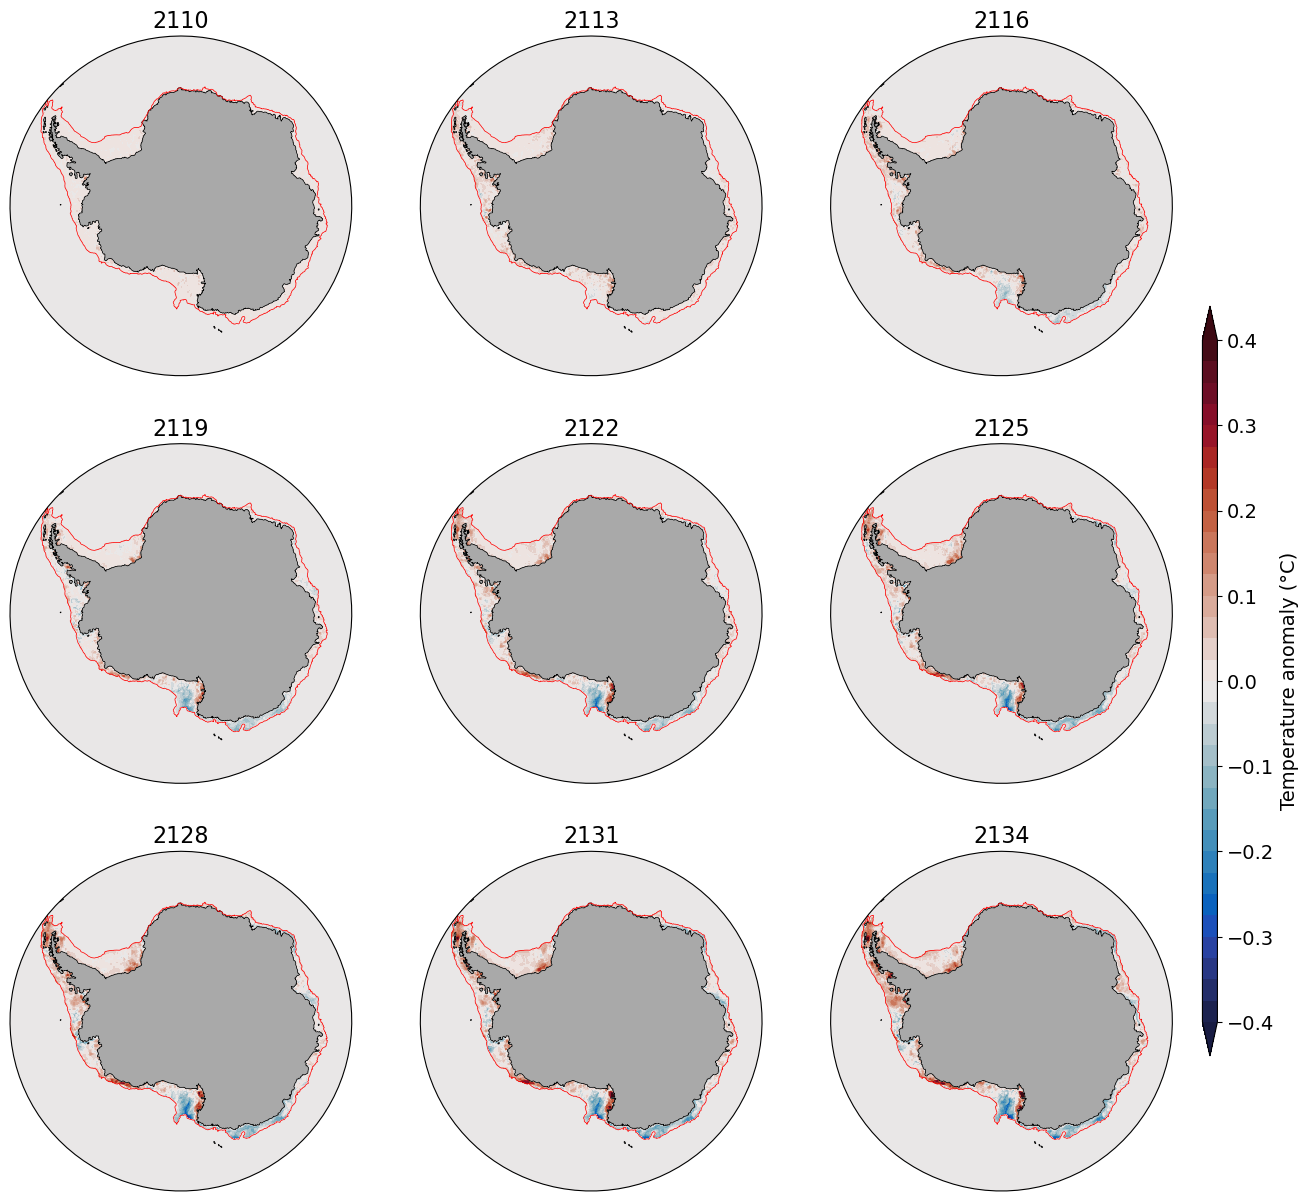

In [33]:
lvls = np.arange(-0.4,0.425,0.025)
annual_circumpolar_plotting(temp_surface_shelf_meltanom_annual_mean)

## Xmovie

Below is a way to make an animation by using Xmovie to show the temperature changes.

In [60]:
from xmovie import Movie

In [ ]:
mov_temp_st_shelf_meltanom_annual_mean = Movie(temp_st_shelf_meltanom_annual_mean)
mov_temp_st_shelf_meltanom_annual_mean.save('movie.gif')

In [ ]:
mov_temp_st_shelf_meltanom = Movie(temp_st_shelf_meltanom)

# Region Selection (Analysis regions p4)

To identify regions of interest, the temperature anomaly averaged over all depths under melting in 2130, which is the 20th year following melting perturbation, is plotted to find regions that have experienced strong temperature changes. The Amundsen-Bellingshausen Seas shelf regions (66°W-150°W) shows an overall strong warming response to the meltwater perturbation. The peak of West Antarctic Peninsula shelf region (60°W-70°W) is, instead, cooling after the meltwater pertubation. Ross Sea (160°E-150°W) and Dumont d'Urville Sea (105°E-160°E) shelf region exhibit opposite thermal changes at different parts, therefore they are both seperated into east and west for studying individually. However, other parts of Antarctic shelf region do not exhibit much changes, e.g. Weddell Sea shelf region (20°W-65°W), thus making the above regions the focus of this study. Therefore, the Antarctic shelf region is divided into six subdomains: Dumont d'Urville Sea, Ross Sea, Amundsen-Bellingshausen Seas, peak of West Antarctic Peninsula, Weddell Sea, Prydz Bay (Figure *).

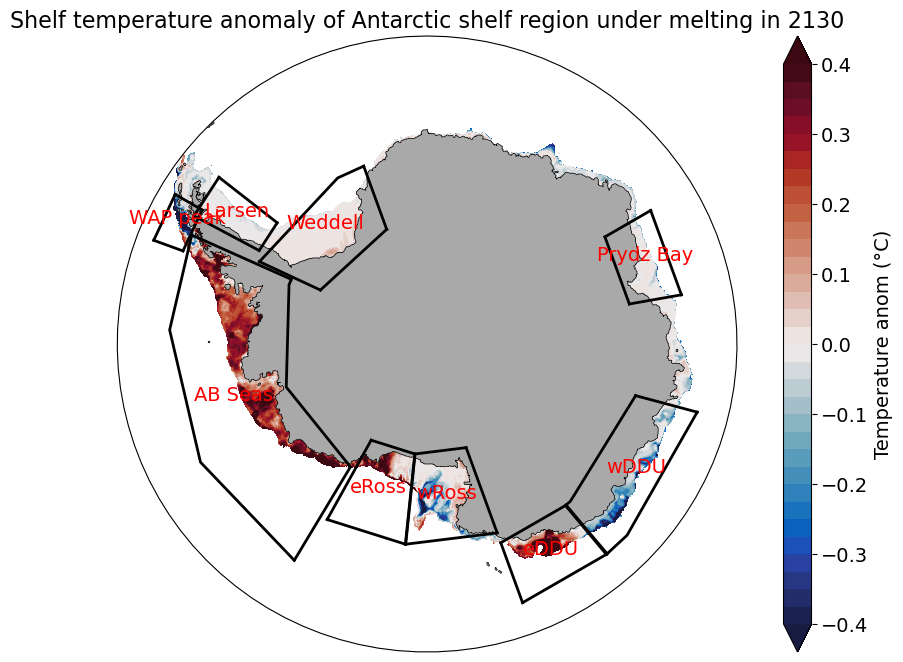

In [35]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -80, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red', transform=ccrs.PlateCarree())

# Plot the shelf region
lvls = np.arange(-0.4,0.425,0.025)
cf = ax.contourf(temp_st_shelf_meltanom_annual_mean.isel(year = 19)['xt_ocean'], 
                  temp_st_shelf_meltanom_annual_mean.isel(year = 19)['yt_ocean'], 
                  temp_st_shelf_meltanom_annual_mean.isel(year = 19), levels = lvls, cmap=cm.cm.balance, 
                  extend = 'both', transform = ccrs.PlateCarree())

plt.title('Shelf temperature anomaly under melting in 2130', fontsize=16)

# Colorbars
cb = plt.colorbar(cf, orientation='vertical')
cb.ax.set_ylabel('Temperature anom (°C)')

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2, transform = ccrs.PlateCarree())
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2, transform = ccrs.PlateCarree())
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2, transform = ccrs.PlateCarree())
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2, transform = ccrs.PlateCarree())
    plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2, region_name, color = 'r', horizontalalignment='center', transform = ccrs.PlateCarree())

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
#drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()

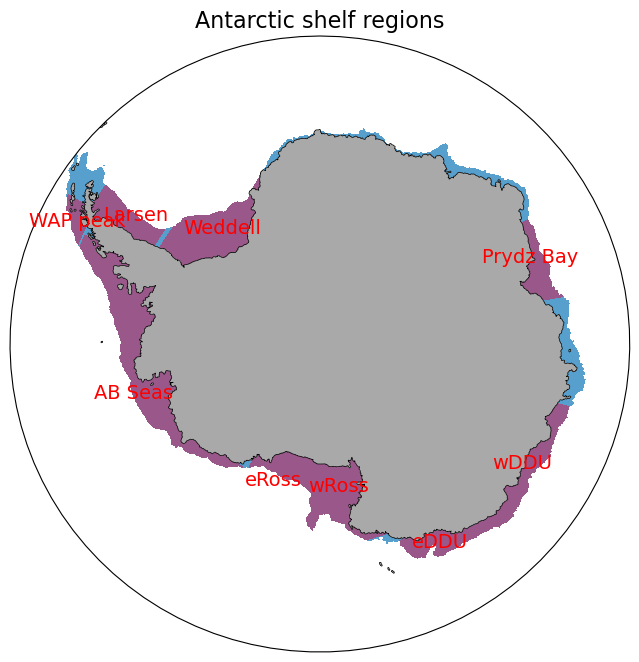

In [36]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())

# Map the plot boundaries to a circle
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2, transform = ccrs.PlateCarree())
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5, transform=ccrs.PlateCarree())

# Plot the shelf region
cf = ax.contourf(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, cmap = 'Blues_r', 
                 extend = 'both', transform = ccrs.PlateCarree(), zorder = 0)
plt.title('Antarctic shelf regions', fontsize=16)

def coloring_region(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    coloring_region = shelf_mask.sel(xt_ocean = slice(bottomleft_lon,topright_lon), yt_ocean = slice(bottomleft_lat,topright_lat))
    cf = ax.contourf(coloring_region['xt_ocean'], coloring_region['yt_ocean'], coloring_region, cmap = 'cmo.thermal', 
                     extend = 'both', transform = ccrs.PlateCarree())
    #plt.plot((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2 + 0.3, 'o', color = 'blue', transform = ccrs.PlateCarree())
    plt.text((bottomleft_lon+topright_lon)/2, (bottomleft_lat+topright_lat)/2 - 0.7, region_name, color = 'red',
             horizontalalignment='center', transform = ccrs.PlateCarree())

# lon limit is from -280 E to 80 E
coloring_region(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
coloring_region(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
coloring_region(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
coloring_region(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
coloring_region(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
coloring_region(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
coloring_region(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
coloring_region(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
coloring_region(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

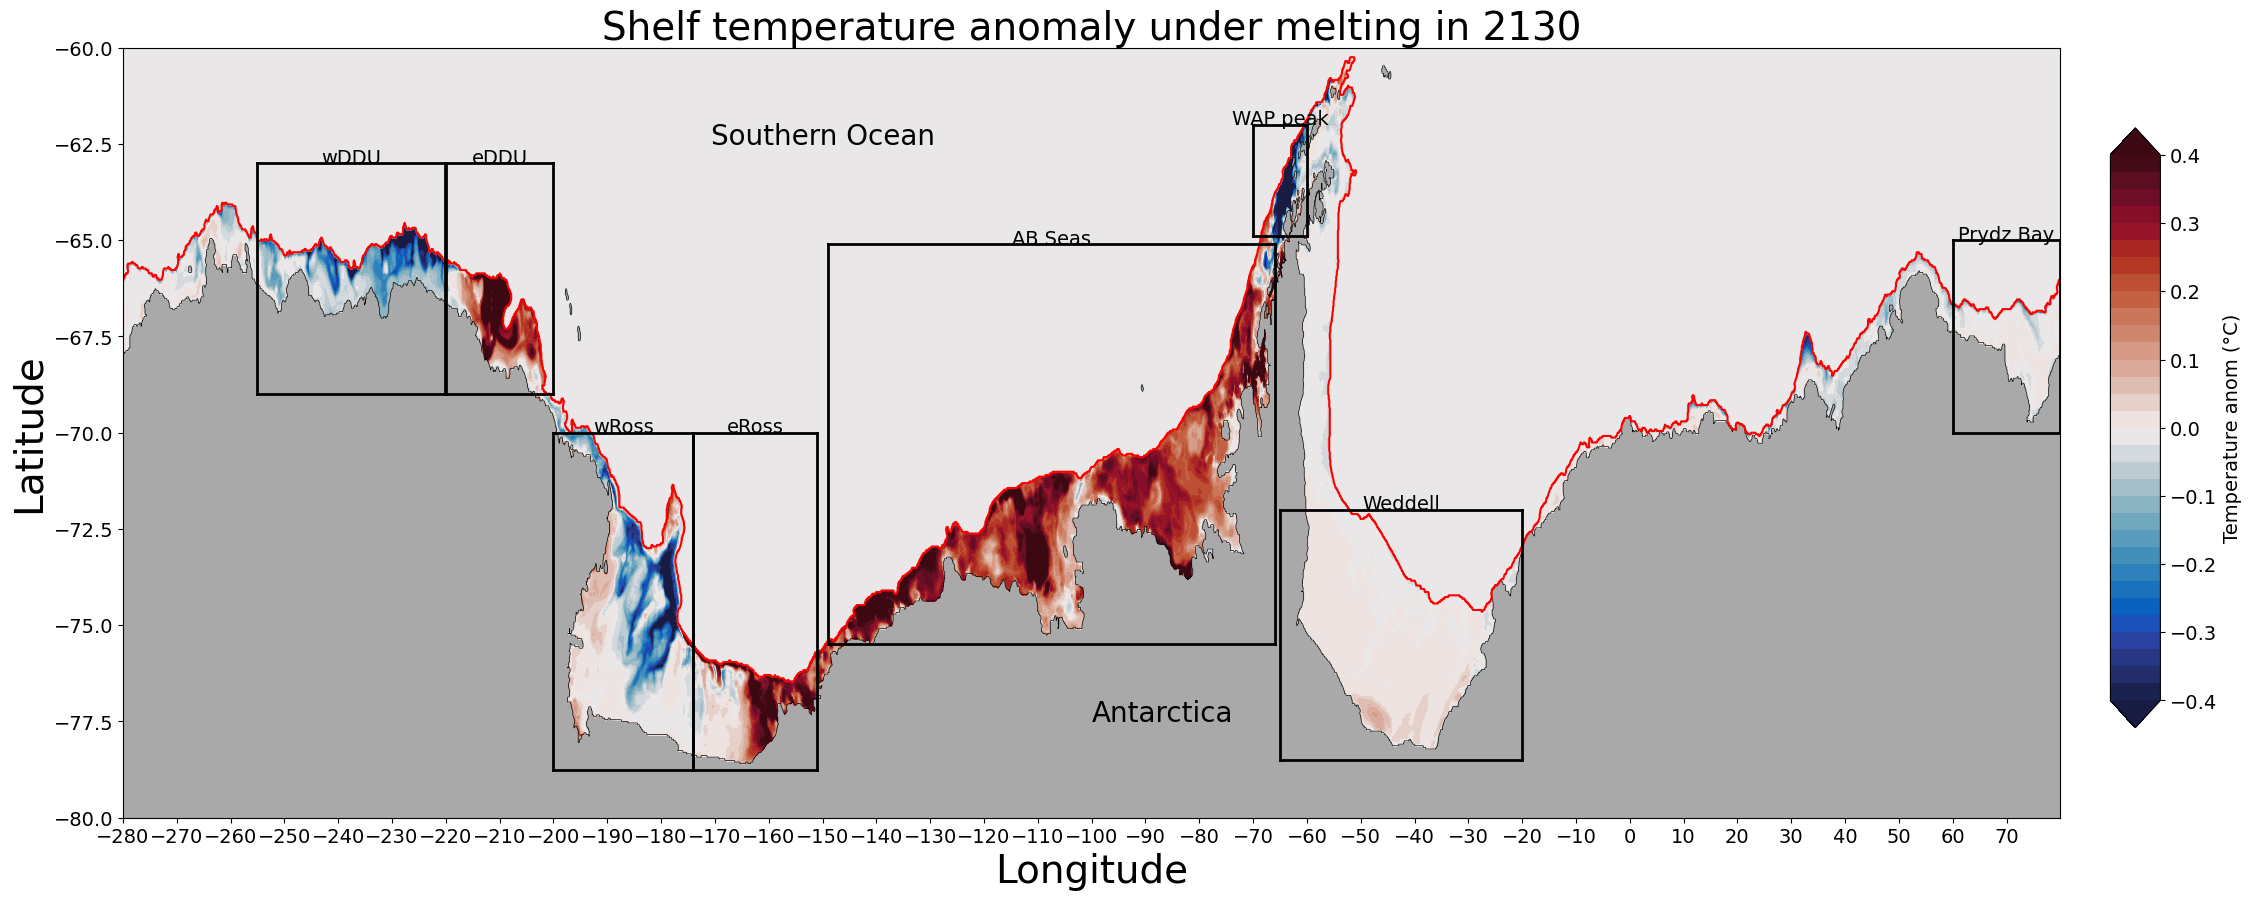

In [27]:
fig=plt.figure(2,(25,10))
ax = plt.subplot()
ax.set_title("Shelf temperature anomaly under melting in 2130", fontsize = 28)

# Plot the shelf region
lvls = np.arange(-0.4,0.425,0.025)
plot = ax.contourf(temp_st_shelf_meltanom_annual_mean.isel(year = 19)['xt_ocean'], 
                  temp_st_shelf_meltanom_annual_mean.isel(year = 19)['yt_ocean'], 
                  temp_st_shelf_meltanom_annual_mean.isel(year = 19), levels = lvls, cmap=cm.cm.balance, 
                  extend = 'both')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label('Temperature anom (°C)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')

ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'black', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-60))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.text((bottomleft_lon+topright_lon)/2, topright_lat, region_name, color = 'black', horizontalalignment='center')

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
#drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()

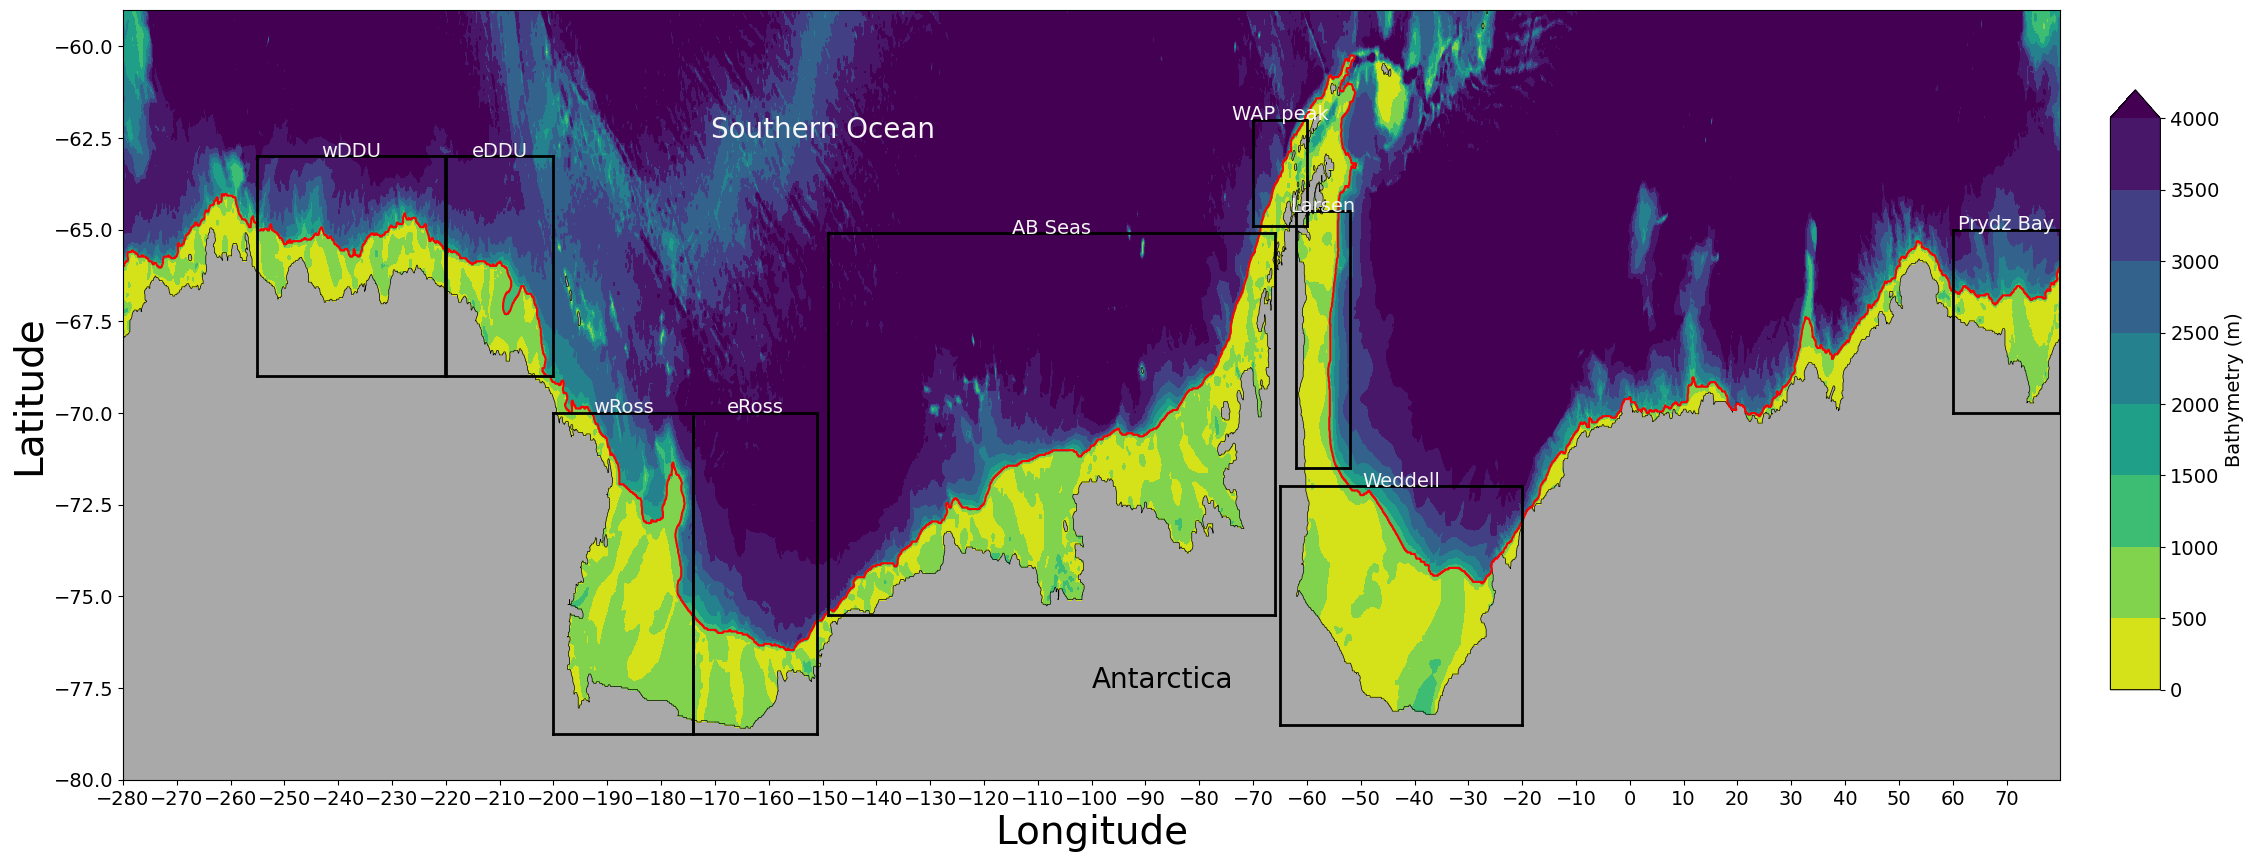

In [105]:
fig=plt.figure(2,(25,10))
ax = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-59)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]   
plot = ax.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')


ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'whitesmoke', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-59))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.text((bottomleft_lon+topright_lon)/2, topright_lat, region_name, color = 'whitesmoke', horizontalalignment='center')

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()

## Transects of Moorman et al. (2020)

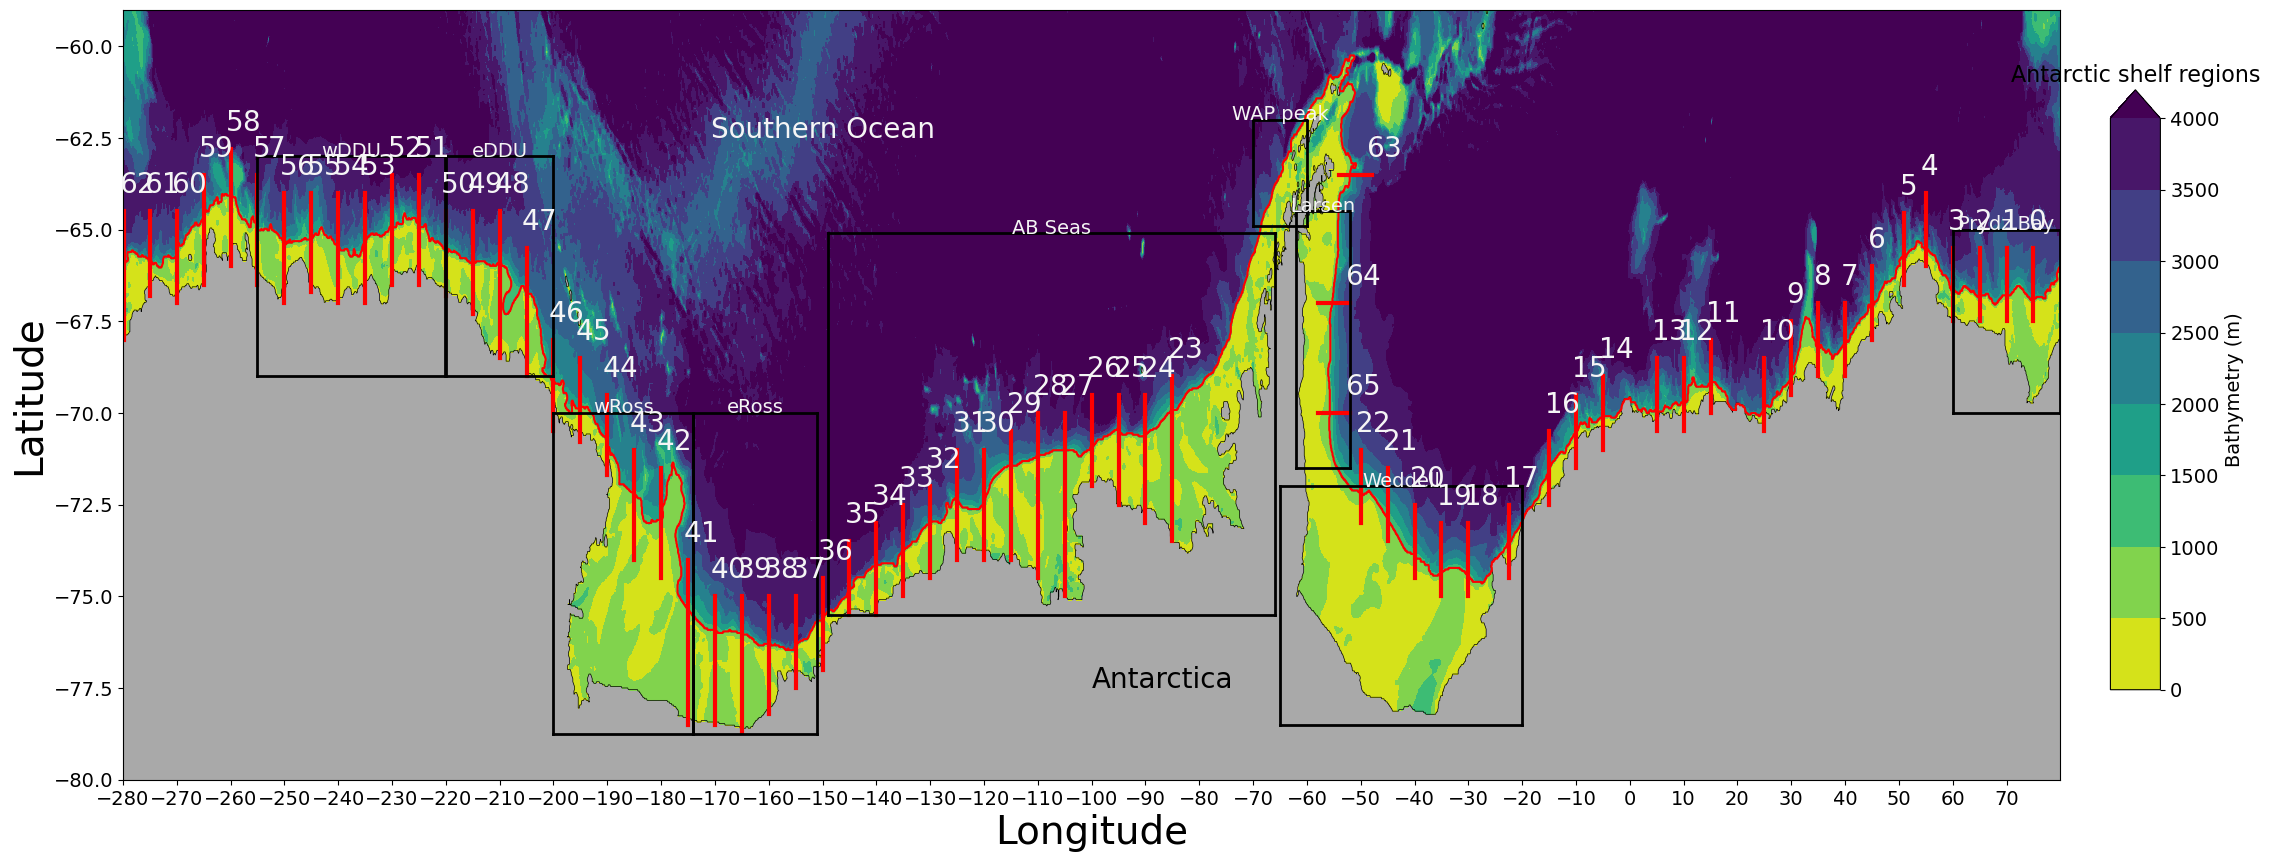

In [131]:
## Vertical & horizontal transects
transect_lons = [75,75,70,70,65,65,60,60,55,55,51,51,45,45,40,40,35,35,30,30,25,25,15,15,10,10,5,5,-5,-5,-10,-10,-15,-15,-22.5,-22.5,-30,-30,-35,-35,-40,-40,-45,-45,-50,-50,-85,-85,-90,-90,-95,-95,-100,-100,-105,-105,-110,-110,-115,-115,-120,-120,-125,-125,-130,-130,-135,-135,-140,-140,-145,-145,-150,-150,-155,-155,-160,-160,-165,-165, -170,-170,-175,-175,-180,-180,-185,-185,-190,-190,-195,-195,-200,-200,-205,-205,-210,-210,-215,-215,-220,-220,-225,-225,-230,-230,-235,-235,-240,-240,-245,-245,-250,-250,-255,-255,-260,-260,-265,-265,-270,-270,-275,-275,-279.8,-279.8,-54,-48,-58,-52,-58,-52]
transect_lats = [-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-67.5,-65.5,-66,-64,-66.5,-64.55,-68,-66,-69,-67,-69,-67,-69.5,-67.5,-70.5,-68.5,-70,-68,-70.5,-68.5,-70.5,-68.5,-71,-69,-71.5,-69.5,-72.5,-70.5,-74.5,-72.5,-75,-73,-75,-73,-74.5,-72.5,-73.5,-71.5,-73,-71,-73.5,-69,-73,-69.5, -72.5,-69.5,-72,-69.5,-75,-70,-74.5,-70,-74,-70.5,-74,-71,-74,-71,-74.5,-72,-75,-72.5,-75.5,-73,-75.5,-73.5,-77,-74.5,-77.5,-75,-78.2,-75,-78.7,-75,-78.5,-75,-78.5,-74, -74.5,-71.5,-74,-71,-71.7,-69.5,-70.8,-68.5,-70.5,-68,-69,-65.5,-68.5,-64.5,-67.3,-64.5,-66.8,-64.5,-66.5,-63.5,-66.5,-63.5,-67,-64,-67,-64,-66.7,-64,-67,-64,-66.5,-63.5,-66,-62.8,-66.5,-63.5,-67,-64.5,-66.8,-64.5,-68,-64.5,-63.5,-63.5,-67,-67,-70,-70]

fig=plt.figure(2,(25,10))
plt.title('Antarctic shelf regions', fontsize=28)
ax = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-59)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]   
plot = ax.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')

ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'whitesmoke', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-59))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

for i in range(66):
    ax.plot(transect_lons[2*i:2*i+2], transect_lats[2*i:2*i+2], color = 'red', linewidth = 3)
    ax.text(transect_lons[2*i+1]-1, transect_lats[2*i+1]+0.5, '$\mathsf{'+str(i)+'}$', fontsize = 20, color = 'whitesmoke')

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.text((bottomleft_lon+topright_lon)/2, topright_lat+0.5, region_name, color = 'whitesmoke', horizontalalignment='center')

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
#drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()

## Velocity field

In [21]:
u_st_shelf_meltanom_20yrs = u_st_shelf_meltanom.sel(time=slice('2130-01-01 00:00:00','2135-12-31 00:00:00'))
u_st_shelf_meltanom_20yrs = u_st_shelf_meltanom_20yrs.mean(dim='time')
v_st_shelf_meltanom_20yrs = v_st_shelf_meltanom.sel(time=slice('2130-01-01 00:00:00','2135-12-31 00:00:00'))
v_st_shelf_meltanom_20yrs = v_st_shelf_meltanom_20yrs.mean(dim='time')

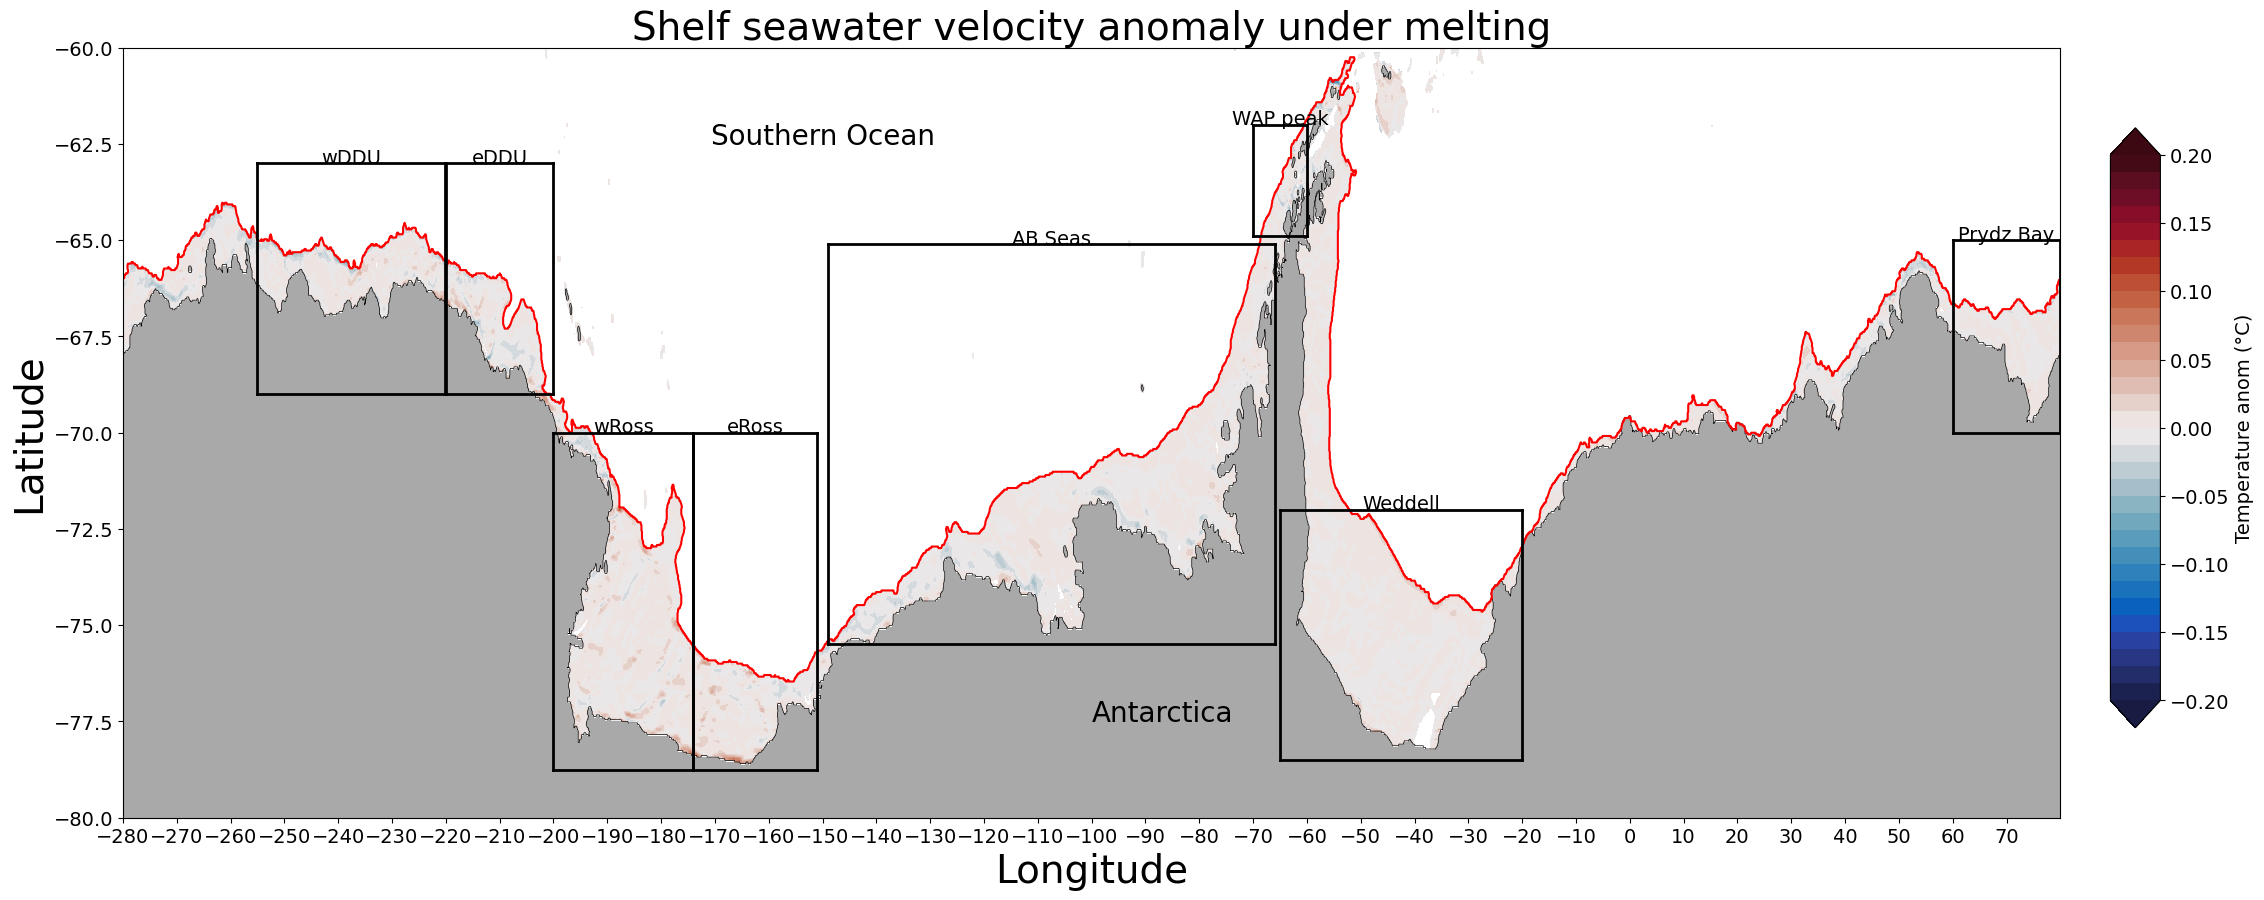

In [22]:
fig=plt.figure(2,(25,10))
ax = plt.subplot()
ax.set_title("Shelf seawater velocity anomaly under melting", fontsize = 28)

# Plot the shelf region
lvls = np.arange(-0.2,0.2125,0.0125)
plot = ax.contourf(u_st_shelf_meltanom_20yrs['xu_ocean'], 
                  u_st_shelf_meltanom_20yrs['yu_ocean'], 
                  u_st_shelf_meltanom_20yrs, levels = lvls, cmap=cm.cm.balance, 
                  extend = 'both')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label('Temperature anom (°C)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')

ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'black', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-60))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.text((bottomleft_lon+topright_lon)/2, topright_lat, region_name, color = 'black', horizontalalignment='center')

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
#drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()